<center>
<h1> General Data Science Case Study </h1>
</center>

<center>
<h3> Allegheny County Home Value Index </h3>
</center>

<center>
<h5> 2022-06-21 Jonathan Hanke </h5> 
</center>
<hr> 


## 0. Python and Data Imports


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

In [2]:
%%time 
df1 = pd.read_csv("../DATA/1. May 2022 Property Assessments/518b583f-7cc8-4f60-94d0-174cc98310dc.csv")

<decorator-gen-61>:2: DtypeWarning: Columns (19,20,29,30,31,38,46,57,83) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 5.51 s, sys: 614 ms, total: 6.12 s
Wall time: 6.12 s


In [3]:
## TO REVIEW AND DELETE:

## Home value index by City


## Define the index as the monthly average housing price for the city
#Compute the monthly housing price per city 



## Determine when a house appears on the market -- 











In [4]:
#df1.columns

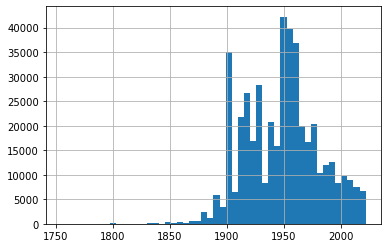

In [5]:
df1['YEARBLT'].hist(bins=50)


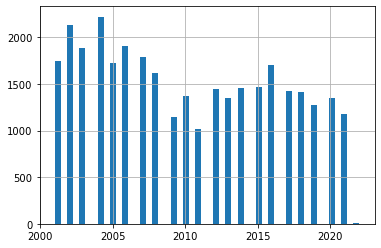

In [6]:
df1[df1['YEARBLT'] > 2000]['YEARBLT'].hist(bins=50)

## Index methodology

1. Start with the population of homes reported sold, and take the average of their last sale values.  
$Z_0$ := average value of all homes at the starting time.


2. For each month, we look at the previous value, then compute the home appreciation.
$A_{h, 1} := (V_{h,0} - V_{h,1})$

which is a 
weighted value


#### Summary of Routines to build the index

- monthly_index_by_selection (**in progress**)
    - MM_DD_YYYY_to_datetime
    - MM_DD_YYYY_to_datetime_with_hyphen
    - timedelta_to_months
    - month_list
    - price_at_last_date_in_input_df_before -- to select data to compute the initial index
    - -----
    - dates_in_same_month
    - get_monthly_sales  (**in progress**) -- to select data to update the index monthly
    
    

#### Supporting Routines for dates

In [7]:
import datetime


## Define Time-related routines:
## -----------------------------

def MM_DD_YYYY_to_datetime(MM_DD_YYYY_str, separator = '/'):
    """
    Converts a MM/DD/YYYY string to a datetime date object.
    """
    from datetime import date
    MM_str, DD_str, YYYY_str = MM_DD_YYYY_str.split(separator) 
    MM = int(MM_str)
    DD = int(DD_str)
    YYYY = int(YYYY_str)
    return datetime.date(YYYY, MM, DD)


def MM_DD_YYYY_to_datetime_with_hyphen(date_str):
    try:
        return MM_DD_YYYY_to_datetime(date_str, separator='-')
    except:
        from numpy import NaN
        return NaN

    
def timedelta_to_months(timediff):
    """
    Returns the number of days in the given timedelta object.
    """
    try:
        return timediff.months
    except:
        from numpy import NaN
        return NaN    

In [8]:
## Enhance the original dataset with datetime types for easier testing
df1['SALEDATE_date'] = df1['SALEDATE'].apply(MM_DD_YYYY_to_datetime_with_hyphen)
df1['PREVSALEDATE_date'] = df1['PREVSALEDATE'].apply(MM_DD_YYYY_to_datetime_with_hyphen)
df1['PREVSALEDATE2_date'] = df1['PREVSALEDATE2'].apply(MM_DD_YYYY_to_datetime_with_hyphen)


In [9]:
def month_list(start_year, start_month, end_year, end_month):
    """
    Computes all months between the start and end dates (inclusive).
    """
    import datetime as dt

    ## Create the start and end dates (as datetime.date objects)
    start_date = dt.date(start_year, start_month, 1)
    end_date = dt.date(end_year, end_month, 1)

    ## Make one_month for incrementing
    from datetime import timedelta
    from dateutil.relativedelta import relativedelta
    one_month = relativedelta(months=1) 
    
    ## Create the desired list of months (as datetime objects)
    month_list = []
    tmp_date = start_date
    while tmp_date <= end_date:
        month_list.append(tmp_date)
        tmp_date += one_month

    ## Return the month list
    return month_list

In [10]:
## Testing month_list()
month_list(2021,11, 2022,6)

[datetime.date(2021, 11, 1),
 datetime.date(2021, 12, 1),
 datetime.date(2022, 1, 1),
 datetime.date(2022, 2, 1),
 datetime.date(2022, 3, 1),
 datetime.date(2022, 4, 1),
 datetime.date(2022, 5, 1),
 datetime.date(2022, 6, 1)]

In [11]:
def price_at_last_date_in_input_df_before(input_df, before_date, addl_field_name_list=[]):
    """
    Compute the dataframe of prices and dates for the last sale date before the 
    given before_date, allowing for some additional input series/fields to be passed through.
    """
    ## Reset the index 
    from copy import deepcopy
    new_input_df = deepcopy(input_df).reset_index()

    ## Create a blank output dataframe 
    import pandas as pd
    output_cols_list = ['last_sale_date_before', 'last_sale_price_before'] + addl_field_name_list
    output_df = pd.DataFrame(index = new_input_df.index, columns=output_cols_list)
    

    ## SANITY CHECK: Columns include 'SALEDATE_date', 'PREVSALEDATE_date', and 'PREVSALEDATE2_date'
    if not 'SALEDATE_date' in new_input_df.columns:
        raise(TypeError, "SALEDATE_date is missing from the input_df columns")
    if not 'PREVSALEDATE_date' in new_input_df.columns:
        raise(TypeError, "PREVSALEDATE_date is missing from the input_df columns")
    if not 'PREVSALEDATE2_date' in new_input_df.columns:
        raise(TypeError, "PREVSALEDATE2_date is missing from the input_df columns")
    
    
    ## Create the new dataframe of latest dates as prices before the given date
    tmp_sale_date = np.nan
    tmp_sale_price = np.nan    
    for index, row in new_input_df.iterrows():
        
        ## Compute the latest sale date and sale price before the given date
        try:
            if row['SALEDATE_date'] < before_date:
                tmp_sale_date = row['SALEDATE_date']
                tmp_sale_price = row['SALEPRICE']
            else:
                try:
                    if row['PREVSALEDATE_date'] < before_date:
                        tmp_sale_date = row['PREVSALEDATE_date']
                        tmp_sale_price = row['PREVSALEPRICE']
                    else:
                        try: 
                            if row['PREVSALEDATE2_date'] < before_date:
                                tmp_sale_date = row['PREVSALEDATE2_date']
                                tmp_sale_price = row['PREVSALEPRICE2']
                        except:
                            pass
                except:
                    pass
        except:
            pass

        
        ## DIAGNOSTIC: 
        #print("")
        #print("index = ", index)
        #print("tmp_sale_date = ", tmp_sale_date)
        #print("tmp_sale_price = ", tmp_sale_price)

        #print("before appending row:  ", output_df.iloc[index])

        
        ## Append the last_sale_date_before and last_sale_price_before
        output_df.iloc[index] = [tmp_sale_date, tmp_sale_price] + [new_input_df.iloc[index][col]  for col in addl_field_name_list]

        
        ## DIAGNOSTIC:
        #print("after appending row:  ", output_df.iloc[index])


        
    ## Return the dataframe
    return output_df



In [12]:
## Testing price_at_last_date_in_input_df_before()
relevant_columns_list = ["SALEDESC", "SALEPRICE", "SALEDATE", \
                             "PREVSALEDATE", "PREVSALEPRICE", \
                             "PREVSALEDATE2", "PREVSALEPRICE2"]
from copy import deepcopy
test_tmp_df = deepcopy(df1.iloc[:10][relevant_columns_list])
test_tmp_df['SALEDATE_date'] = test_tmp_df['SALEDATE'].apply(MM_DD_YYYY_to_datetime_with_hyphen)
test_tmp_df['PREVSALEDATE_date'] = test_tmp_df['PREVSALEDATE'].apply(MM_DD_YYYY_to_datetime_with_hyphen)
test_tmp_df['PREVSALEDATE2_date'] = test_tmp_df['PREVSALEDATE2'].apply(MM_DD_YYYY_to_datetime_with_hyphen)


#test_before_date = dt.date(2020, 1, 1)
#price_at_last_date_in_input_df_before(test_tmp_df, test_before_date)

import datetime as dt
test_before_date = dt.date(2015, 1, 1)
price_at_last_date_in_input_df_before(test_tmp_df, test_before_date)


last_sale_date_before last_sale_price_before
0            2010-08-02                 424000
1            2009-01-16                 132000
2            2011-07-20                 311500
3            2014-12-09                 253099
4            2013-08-29                 320000
5            2014-09-12                 615000
6            2014-09-24                 290140
7            2008-04-16                 892900
8            2009-10-16                 845450
9            2013-02-15                 660000

In [13]:
test_before_date = dt.date(1915, 1, 1)
price_at_last_date_in_input_df_before(test_tmp_df, test_before_date)


last_sale_date_before last_sale_price_before
0                   NaN                    NaN
1                   NaN                    NaN
2                   NaN                    NaN
3                   NaN                    NaN
4                   NaN                    NaN
5                   NaN                    NaN
6                   NaN                    NaN
7                   NaN                    NaN
8                   NaN                    NaN
9                   NaN                    NaN

In [14]:
test_before_date = dt.date(2015, 1, 1)
price_at_last_date_in_input_df_before(test_tmp_df, test_before_date)


last_sale_date_before last_sale_price_before
0            2010-08-02                 424000
1            2009-01-16                 132000
2            2011-07-20                 311500
3            2014-12-09                 253099
4            2013-08-29                 320000
5            2014-09-12                 615000
6            2014-09-24                 290140
7            2008-04-16                 892900
8            2009-10-16                 845450
9            2013-02-15                 660000

In [15]:
def dates_in_same_month(date1, date2):
    """
    Determine if two (datetime) dates are in the same month.
    """
    try:
        return ((date1.year == date2.year) and (date1.month == date2.month))
    except:
        return False

In [61]:
dates_in_same_month(dt.date(2019,10,1), dt.date(2019,10,19))

True

In [92]:
def get_monthly_sales(input_df, given_month_date, addl_field_name_list=[]):
    """
    Compute the series of prices and dates for the sales occurring in the month given by
    month_date, allowing for some additional input series/fields to be passed through.
    """
    ## Misc Imports
    import numpy as np
    import pandas as pd
    
    ## Rename the input index  -- TO REMOVE LATER
    new_input_df = input_df    

    ## Reset the input index 
#    from copy import deepcopy
#    new_input_df = deepcopy(input_df).reset_index()    

    ## Create a blank output dataframe 
    output_cols_list = ['curr_sale_price', 'prev_sale_price'] + addl_field_name_list
    output_df = pd.DataFrame(columns=output_cols_list)
    
    
    ## Determine the rows with sales occrring in the given month, and the relevant fields
    row_dict_list = []
    for index, row in new_input_df.iterrows():

        ## DIAGNOSTIC
        print()
        print("index = ", index)
        print("given_month_date = ", given_month_date)
        
        
        ## Determine the relevant fields
        for date_field in ['SALEDATE_date', 'PREVSALEDATE_date', 'PREVSALEDATE2_date']:
            sale_date = row[date_field]            

            ## DIAGNOSTIC
#            print()
            print("  date_field = ", date_field)
            print("  sale_date = ", sale_date)

            
            if dates_in_same_month(given_month_date, sale_date):
                row_dict = {}

                ## DIAGNOSTIC
                print()
                print("Sale Month Match on row", row)
                
                ## Determine the relevant sale prices
                if (date_field == 'SALEDATE_date'):
                    row_dict['curr_sale_price'] = row['SALEPRICE']
                    row_dict['prev_sale_price'] = row['PREVSALEPRICE']
                elif (date_field == 'PREVSALEDATE_date'):
                    row_dict['curr_sale_price'] = row['PREVSALEPRICE']
                    row_dict['prev_sale_price'] = row['PREVSALEPRICE2']
                else:
                    row_dict['curr_sale_price'] = row['PREVSALEPRICE2']
                    row_dict['prev_sale_price'] = np.nan 
                    
                ## Update the previous sale price to handle zero and NaN values
                if (row_dict['prev_sale_price'] == np.nan) or (row_dict['prev_sale_price'] == 0):
                    row_dict['curr_sale_price'] = row_dict['curr_sale_price'] * 0.2 ## MADE A CHOICE HERE

                
                ## Append the additional field names
                for tmp_field in addl_field_name_list:
                    row_dict[tnp_field] = row[tnp_field]
                                        
                ## Append this row dictionary to create the output dataframe
                row_dict_list.append(row_dict)


    ## DIAGNOSTIC
    print()
    print("len(row_dict_list) = ", len(row_dict_list))
    print("row_dict_list = ", row_dict_list)
    
                
    ## Populate the output dataframe
#    for tmp_row_dict in row_dict_list:
#        output_df.append(tmp_row_dict)
    output_df = pd.DataFrame(row_dict_list, columns=output_cols_list)
            
    ## Return the output dataframe
    return output_df
    
    
    
    

In [90]:
## Testing get_monthly_sales() -- IN PROGRESS
#month_test_df = get_monthly_sales(McKeesport_city_small_testing_df.iloc[:10], dt.date(2019,10,1))
month_test_df = get_monthly_sales(McKeesport_city_small_testing_df.iloc[:10], dt.date(1992,6,1))
month_test_df


index =  14008
given_month_date =  1992-06-01
  date_field =  SALEDATE_date
  sale_date =  1924-08-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  14009
given_month_date =  1992-06-01
  date_field =  SALEDATE_date
  sale_date =  1992-06-17

Sale Month Match on row PARID                 0380J00116000000
PROPERTYHOUSENUM                     0
PROPERTYFRACTION                      
PROPERTYADDRESS           LAWNDALE AVE
PROPERTYCITY               MC KEESPORT
                            ...       
TRACT                              NaN
BLOCK_GROUP                        NaN
SALEDATE_date               1992-06-17
PREVSALEDATE_date                  NaN
PREVSALEDATE2_date                 NaN
Name: 14009, Length: 98, dtype: object
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  14010
given_month_date =  1992-06-01
  date_field =  SALEDATE_date
  sale_dat

curr_sale_price  prev_sale_price
0           2000.0              NaN

In [91]:
month_test_df

curr_sale_price  prev_sale_price
0           2000.0              NaN

In [89]:
McKeesport_city_small_testing_df[['SALEDATE', 'SALEPRICE', 'PREVSALEDATE', 'PREVSALEPRICE']].iloc[:10]

SALEDATE  SALEPRICE PREVSALEDATE  PREVSALEPRICE
14008   08-13-1924        0.0          NaN            NaN
14009   06-17-1992     2000.0          NaN            NaN
14010   10-22-2019        1.0   05-01-2017            1.0
14011   08-17-2021        0.0   02-18-1999          600.0
14775   09-09-1975        0.0          NaN            NaN
17125   11-16-1954        0.0          NaN            NaN
19265   03-29-1976        1.0          NaN            NaN
19553   03-16-2018        1.0   04-30-1999        21000.0
19554   08-16-1979        0.0          NaN            NaN
111426  05-05-1950        0.0          NaN            NaN

In [95]:
## Testing get_monthly_sales() -- IN PROGRESS
get_monthly_sales(McKeesport_city_small_testing_df.iloc[:100000], dt.date(2019,10,1))


index =  14008
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1924-08-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  14009
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-06-17
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  14010
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-10-22

Sale Month Match on row PARID                 0382A00309000000
PROPERTYHOUSENUM                  1005
PROPERTYFRACTION                      
PROPERTYADDRESS              WALNUT ST
PROPERTYCITY               MC KEESPORT
                            ...       
TRACT                              NaN
BLOCK_GROUP                        NaN
SALEDATE_date               2019-10-22
PREVSALEDATE_date           2017-05-01
PREVSALEDATE2_date          2003-04-25
Name: 14010, Length: 98

  sale_date =  nan

index =  111679
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-07-26
  date_field =  PREVSALEDATE_date
  sale_date =  1989-01-20
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111680
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1945-12-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111681
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-06-25
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111682
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-06-28
  date_field =  PREVSALEDATE_date
  sale_date =  1949-08-15
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111683
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-01-22
  date_field =  PRE

  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111832
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1967-09-19
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111833
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-10-11
  date_field =  PREVSALEDATE_date
  sale_date =  2001-01-23
  date_field =  PREVSALEDATE2_date
  sale_date =  2000-11-22

index =  111834
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-11-28
  date_field =  PREVSALEDATE_date
  sale_date =  2009-06-24
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  111835
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-06-05
  date_field =  PREVSALEDATE_date
  sale_date =  1992-06-16
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111836
given_month_date =  2019-10-01


  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111923
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1928-03-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111924
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-04-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  111984
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-01-26
  date_field =  PREVSALEDATE_date
  sale_date =  2007-09-07
  date_field =  PREVSALEDATE2_date
  sale_date =  1983-02-03

index =  111985
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-06-02
  date_field =  PREVSALEDATE_date
  sale_date =  2014-03-21
  date_field =  PREVSALEDATE2_date
  sale_date =  2007-07-17

index =  111986
give

  sale_date =  2020-09-30
  date_field =  PREVSALEDATE_date
  sale_date =  2008-04-18
  date_field =  PREVSALEDATE2_date
  sale_date =  1990-09-19

index =  112073
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-06-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112074
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-03-15
  date_field =  PREVSALEDATE_date
  sale_date =  1982-04-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112075
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-04-14
  date_field =  PREVSALEDATE_date
  sale_date =  2003-02-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1991-10-29

index =  112076
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-10-14
  date_field =  PREVSALEDATE_date
  sale_date =  2000-01-04
  date_field =  PREVSALEDATE2_date


  date_field =  SALEDATE_date
  sale_date =  2015-12-17
  date_field =  PREVSALEDATE_date
  sale_date =  2010-06-17
  date_field =  PREVSALEDATE2_date
  sale_date =  1993-01-04

index =  112224
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-01-04
  date_field =  PREVSALEDATE_date
  sale_date =  2005-10-18
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-09-19

index =  112225
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-10-21
  date_field =  PREVSALEDATE_date
  sale_date =  2008-06-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1957-09-16

index =  112226
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1976-12-07
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112227
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-02-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  dat

  sale_date =  1997-12-23
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112408
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-06-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112409
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-12-19
  date_field =  PREVSALEDATE_date
  sale_date =  2008-10-15
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-05-19

index =  112410
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-09-08
  date_field =  PREVSALEDATE_date
  sale_date =  2001-11-07
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-10-29

index =  112411
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-02-08
  date_field =  PREVSALEDATE_date
  sale_date =  1979-06-11
  date_field =  PREVSALEDATE2_date
  sale_

  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112569
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-11-10
  date_field =  PREVSALEDATE_date
  sale_date =  1995-11-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112570
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-02-09
  date_field =  PREVSALEDATE_date
  sale_date =  2010-02-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1985-06-03

index =  112571
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1983-06-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112572
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1986-09-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112573
given_month

index =  112732
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-06-04
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112733
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-07-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112734
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-09-29
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112735
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-01-30
  date_field =  PREVSALEDATE_date
  sale_date =  1999-11-10
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  112736
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-01-30
  date_field =  PREVSALEDATE_dat

  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112885
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-06-08
  date_field =  PREVSALEDATE_date
  sale_date =  1997-09-26
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112886
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-09-06
  date_field =  PREVSALEDATE_date
  sale_date =  1992-12-31
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112887
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-03-10
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112888
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-02-17
  date_field =  PREVSALEDATE_date
  sale_date =  1998-06-02
  date_field =  PREVSALEDATE2_date
  sale_date =  1975-08-19

index =  112889
given_month_date =  2019-10-01
  date_

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1990-08-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112980
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1990-08-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112981
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-06-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  112982
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-10-29
  date_field =  PREVSALEDATE_date
  sale_date =  2010-07-19
  date_field =  PREVSALEDATE2_date
  sale_date =  2007-05-04

index =  112984
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-06-16
  date_field =  PREVSALEDATE_date
  sale_date =  1991-1

index =  113136
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-07-11
  date_field =  PREVSALEDATE_date
  sale_date =  2005-03-18
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-02-18

index =  113137
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-11-06
  date_field =  PREVSALEDATE_date
  sale_date =  2002-01-18
  date_field =  PREVSALEDATE2_date
  sale_date =  1986-11-13

index =  113138
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-11-06
  date_field =  PREVSALEDATE_date
  sale_date =  1989-10-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113139
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-09-29
  date_field =  PREVSALEDATE_date
  sale_date =  1978-01-10
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113140
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-12-27
  date_fiel

  date_field =  SALEDATE_date
  sale_date =  1992-05-21
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113270
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1978-10-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113271
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-11-20
  date_field =  PREVSALEDATE_date
  sale_date =  1991-05-03
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113272
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-06-23
  date_field =  PREVSALEDATE_date
  sale_date =  1989-06-01
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113273
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-01-20
  date_field =  PREVSALEDATE_date
  sale_date =  2006-06-29
  date_field =  PREVSALEDA

index =  113378
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-05-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113379
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-04-17
  date_field =  PREVSALEDATE_date
  sale_date =  1966-05-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113380
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-03-13
  date_field =  PREVSALEDATE_date
  sale_date =  2008-05-02
  date_field =  PREVSALEDATE2_date
  sale_date =  2007-12-04

index =  113381
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1983-01-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113382
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-09-23
  date_field =  PREVSALEDATE_dat

  sale_date =  1970-04-24
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113531
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-12-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113532
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-11-13
  date_field =  PREVSALEDATE_date
  sale_date =  2000-12-05
  date_field =  PREVSALEDATE2_date
  sale_date =  1988-06-01

index =  113533
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-07-18
  date_field =  PREVSALEDATE_date
  sale_date =  1982-10-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113534
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1978-05-24
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  113535
given_month_date =  2019-10-01
  date_

index =  127006
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-05-23
  date_field =  PREVSALEDATE_date
  sale_date =  2006-09-26
  date_field =  PREVSALEDATE2_date
  sale_date =  1981-04-17

index =  127007
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-05-23
  date_field =  PREVSALEDATE_date
  sale_date =  2006-09-26
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  127008
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-05-23
  date_field =  PREVSALEDATE_date
  sale_date =  2006-08-06
  date_field =  PREVSALEDATE2_date
  sale_date =  1954-04-12

index =  127009
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-01-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  127023
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-12-11
  date_field =  PR

index =  128717
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1983-05-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  128741
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-04-01
  date_field =  PREVSALEDATE_date
  sale_date =  2004-03-12
  date_field =  PREVSALEDATE2_date
  sale_date =  2003-09-09

index =  128742
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1930-03-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  128743
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-03-16
  date_field =  PREVSALEDATE_date
  sale_date =  1986-02-03
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  128744
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-02-17
  date_field =  PREVSALEDATE_dat

  date_field =  PREVSALEDATE2_date
  sale_date =  1999-11-30

index =  129903
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-02-11
  date_field =  PREVSALEDATE_date
  sale_date =  2011-01-10
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-12-13

index =  129904
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-03-10
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  129905
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-12-07
  date_field =  PREVSALEDATE_date
  sale_date =  1997-08-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  129906
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-05-20
  date_field =  PREVSALEDATE_date
  sale_date =  2019-09-17
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-07-13

index =  129907
given_month_date =  2019-10-01
  date_field

  sale_date =  2006-09-28
  date_field =  PREVSALEDATE_date
  sale_date =  2004-09-30
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-06-28

index =  129997
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-02-18
  date_field =  PREVSALEDATE_date
  sale_date =  1998-12-03
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  129998
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1980-01-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  129999
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-09-13
  date_field =  PREVSALEDATE_date
  sale_date =  2017-10-31
  date_field =  PREVSALEDATE2_date
  sale_date =  1997-01-02

index =  130000
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-05-01
  date_field =  PREVSALEDATE_date
  sale_date =  2020-02-19
  date_field =  PREVSALEDATE

  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130085
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-07-24
  date_field =  PREVSALEDATE_date
  sale_date =  2008-09-03
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-09-03

index =  130086
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1986-12-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130087
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-07-03
  date_field =  PREVSALEDATE_date
  sale_date =  2002-04-19
  date_field =  PREVSALEDATE2_date
  sale_date =  1984-04-02

index =  130088
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-06-25
  date_field =  PREVSALEDATE_date
  sale_date =  2007-04-18
  date_field =  PREVSALEDATE2_date
  sale_date =  1989-02-17

index 

index =  130176
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-12-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130177
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-12-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130178
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1950-08-25
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130179
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1959-07-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130180
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1973-06-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan


index =  130255
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-09-17
  date_field =  PREVSALEDATE_date
  sale_date =  1974-12-13
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130256
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-09-17
  date_field =  PREVSALEDATE_date
  sale_date =  1975-02-04
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130257
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-09-17
  date_field =  PREVSALEDATE_date
  sale_date =  1975-07-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130259
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1984-12-07
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130260
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-08-28
  date_field =  PREVSALEDATE_dat

  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130347
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-03-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130348
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1970-09-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130349
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1923-09-12
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130350
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-10-30
  date_field =  PREVSALEDATE_date
  sale_date =  1993-08-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130351
given_month_date =  2019-

index =  130498
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-06-01
  date_field =  PREVSALEDATE_date
  sale_date =  2006-12-04
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-12-04

index =  130499
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-07-12
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130500
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-07-24
  date_field =  PREVSALEDATE_date
  sale_date =  1959-10-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130501
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-12-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130502
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1977-05-05
  date_field =  PREVSALEDATE_dat

  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130617
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-07-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130618
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-02-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130619
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-05-29
  date_field =  PREVSALEDATE_date
  sale_date =  1998-02-20
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130620
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1942-09-19
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130621
given_month_date =  2019-10-01
  date_field =  SALEDATE_dat

  date_field =  SALEDATE_date
  sale_date =  1976-10-15
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130746
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1905-09-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130747
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-01-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130748
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-03-21
  date_field =  PREVSALEDATE_date
  sale_date =  1972-01-10
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130749
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-10-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sal

  date_field =  PREVSALEDATE_date
  sale_date =  1968-05-17
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130894
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-07-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130895
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-05-06
  date_field =  PREVSALEDATE_date
  sale_date =  1997-11-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130896
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-01-21
  date_field =  PREVSALEDATE_date
  sale_date =  2009-02-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-01-25

index =  130897
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-07-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130898
give

  sale_date =  1997-04-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  130963
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-04-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131013
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-05-09
  date_field =  PREVSALEDATE_date
  sale_date =  1982-02-12
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131014
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-09-26
  date_field =  PREVSALEDATE_date
  sale_date =  2004-08-24
  date_field =  PREVSALEDATE2_date
  sale_date =  1987-12-31

index =  131015
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-06-26
  date_field =  PREVSALEDATE_date
  sale_date =  1984-02-07
  date_field =  PREVSALEDATE2_date
  sale_date = 

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131114
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1979-03-27
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131115
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-11-05
  date_field =  PREVSALEDATE_date
  sale_date =  2005-01-26
  date_field =  PREVSALEDATE2_date
  sale_date =  2003-11-14

index =  131116
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-08-02
  date_field =  PREVSALEDATE_date
  sale_date =  1997-10-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131117
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-11-21
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131118
given_month_date =  2019-10-01
  date_field =  SALEDATE_d

  sale_date =  1989-06-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131281
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-06-07
  date_field =  PREVSALEDATE_date
  sale_date =  2007-04-18
  date_field =  PREVSALEDATE2_date
  sale_date =  1991-06-20

index =  131282
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-08-18
  date_field =  PREVSALEDATE_date
  sale_date =  1986-08-21
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131283
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-07-16
  date_field =  PREVSALEDATE_date
  sale_date =  2013-05-14
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-06-16

index =  131284
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1964-05-27
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131285
given_month_date =  2019

  date_field =  PREVSALEDATE_date
  sale_date =  1996-01-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131438
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-07-14
  date_field =  PREVSALEDATE_date
  sale_date =  2008-02-06
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-02-15

index =  131439
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-08-25
  date_field =  PREVSALEDATE_date
  sale_date =  2009-04-22
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-06-03

index =  131440
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-03-08
  date_field =  PREVSALEDATE_date
  sale_date =  1978-07-21
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131441
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-06-24
  date_field =  PREVSALEDATE_date
  sale_date =  2015-02-11
  date_field =  PREVSALEDATE2_date
  sale_date =  2007

  sale_date =  2000-01-27
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131529
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-09-24
  date_field =  PREVSALEDATE_date
  sale_date =  1950-09-15
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131530
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-10-08
  date_field =  PREVSALEDATE_date
  sale_date =  2009-08-12
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-09-23

index =  131531
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1966-10-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131532
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1986-07-14
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

i

  date_field =  SALEDATE_date
  sale_date =  2013-05-06
  date_field =  PREVSALEDATE_date
  sale_date =  2005-08-26
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-06-02

index =  131699
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-04-20
  date_field =  PREVSALEDATE_date
  sale_date =  1999-10-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131700
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-01-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131701
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1979-11-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131702
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-07-30
  date_field =  PREVSALEDATE_date
  sale_date =  1998-08-03
  date_field =  PRE

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-04-27
  date_field =  PREVSALEDATE_date
  sale_date =  1993-08-25
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  131865
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-05-04
  date_field =  PREVSALEDATE_date
  sale_date =  2012-01-06
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-10-17

index =  131866
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-05-04
  date_field =  PREVSALEDATE_date
  sale_date =  2012-01-06
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-10-17

index =  131867
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-05-04
  date_field =  PREVSALEDATE_date
  sale_date =  2012-01-06
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-10-17

index =  131868
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-07-12
  date_field =  PREV

index =  132024
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-09-24
  date_field =  PREVSALEDATE_date
  sale_date =  2006-06-21
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-06-11

index =  132025
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-09-20
  date_field =  PREVSALEDATE_date
  sale_date =  2006-06-19
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-06-07

index =  132026
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-09-24
  date_field =  PREVSALEDATE_date
  sale_date =  2006-06-21
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-06-11

index =  132027
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-03-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132028
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1990-08-13
  date_fiel

  sale_date =  nan

index =  132202
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-01-10
  date_field =  PREVSALEDATE_date
  sale_date =  1994-11-04
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132203
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-05-01
  date_field =  PREVSALEDATE_date
  sale_date =  2020-02-19
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-06-28

index =  132204
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-09-09
  date_field =  PREVSALEDATE_date
  sale_date =  2009-08-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1986-09-19

index =  132205
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1953-09-25
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132206
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1908-08-0

  sale_date =  2002-05-20

index =  132307
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1947-03-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132308
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1990-10-17
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132309
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1912-10-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132310
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-04-28
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132311
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1935-01-16
  date_field =  PRE

  date_field =  PREVSALEDATE_date
  sale_date =  2002-10-08
  date_field =  PREVSALEDATE2_date
  sale_date =  1988-05-03

index =  132445
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-03-11
  date_field =  PREVSALEDATE_date
  sale_date =  2011-11-15
  date_field =  PREVSALEDATE2_date
  sale_date =  2011-08-04

index =  132446
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-04-10
  date_field =  PREVSALEDATE_date
  sale_date =  1995-02-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132447
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-02-04
  date_field =  PREVSALEDATE_date
  sale_date =  2004-10-22
  date_field =  PREVSALEDATE2_date
  sale_date =  1999-10-01

index =  132448
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-06-15
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan



index =  132546
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-12-10
  date_field =  PREVSALEDATE_date
  sale_date =  2002-11-06
  date_field =  PREVSALEDATE2_date
  sale_date =  2001-05-10

index =  132547
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-07-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132548
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-12-23
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132549
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-11-15
  date_field =  PREVSALEDATE_date
  sale_date =  2009-10-29
  date_field =  PREVSALEDATE2_date
  sale_date =  2007-03-29

index =  132550
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1975-10-29
  date_field =  PREVSALE

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132609
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1979-10-23
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132610
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-12-22
  date_field =  PREVSALEDATE_date
  sale_date =  1987-12-17
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132611
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1955-07-21
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132612
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1986-05-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132613
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  na


index =  132675
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1980-10-12
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132676
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-05-03
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132677
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-10-01
  date_field =  PREVSALEDATE_date
  sale_date =  2008-05-14
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-06-29

index =  132678
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-08-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132679
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-06-23
  date_field =  PREVSALEDATE_da

index =  132766
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-04-12
  date_field =  PREVSALEDATE_date
  sale_date =  2015-03-31
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-09-17

index =  132767
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-08-19
  date_field =  PREVSALEDATE_date
  sale_date =  2003-02-06
  date_field =  PREVSALEDATE2_date
  sale_date =  1951-10-31

index =  132768
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-01-17
  date_field =  PREVSALEDATE_date
  sale_date =  2010-11-19
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-10-04

index =  132769
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-10-01
  date_field =  PREVSALEDATE_date
  sale_date =  2001-01-26
  date_field =  PREVSALEDATE2_date
  sale_date =  2000-11-21

index =  132770
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1979-11-

index =  132860
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-09-07
  date_field =  PREVSALEDATE_date
  sale_date =  1999-07-07
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-01-04

index =  132861
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-05-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132862
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-10-07
  date_field =  PREVSALEDATE_date
  sale_date =  2020-05-12
  date_field =  PREVSALEDATE2_date
  sale_date =  1974-10-31

index =  132863
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-06-24
  date_field =  PREVSALEDATE_date
  sale_date =  2002-04-19
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  132864
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-09-11
  date_fiel

  sale_date =  2014-01-13

index =  132964
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-06-06
  date_field =  PREVSALEDATE_date
  sale_date =  2006-12-04
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-05-09

index =  132965
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-04-03
  date_field =  PREVSALEDATE_date
  sale_date =  2018-04-27
  date_field =  PREVSALEDATE2_date
  sale_date =  1989-10-31

index =  132966
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-02-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132967
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-02-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  132968
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-01-2

  date_field =  SALEDATE_date
  sale_date =  1988-12-19
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133069
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-05-12
  date_field =  PREVSALEDATE_date
  sale_date =  1983-11-01
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133070
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133071
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133072
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-09-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan


  sale_date =  1997-04-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133179
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-04-30
  date_field =  PREVSALEDATE_date
  sale_date =  2012-08-16
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-08-15

index =  133180
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-05-03
  date_field =  PREVSALEDATE_date
  sale_date =  2006-03-03
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-03-03

index =  133181
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-06-08
  date_field =  PREVSALEDATE_date
  sale_date =  2002-07-19
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-07-19

index =  133182
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-07-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133183
given_month_date 

  sale_date =  1921-10-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133281
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1968-02-09
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133282
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133283
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-04-20
  date_field =  PREVSALEDATE_date
  sale_date =  1994-07-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133284
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-06-09
  date_field =  PREVSALEDATE_date
  sale_date =  1990-08-31
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index = 

index =  133383
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE_date
  sale_date =  2017-06-07
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133384
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-08-10
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133385
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-05-26
  date_field =  PREVSALEDATE_date
  sale_date =  1990-04-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133386
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-04-28
  date_field =  PREVSALEDATE_date
  sale_date =  2011-02-03
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-02-12

index =  133387
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-12-14
  date_field =  PREVSALEDATE_dat

  sale_date =  2013-12-30
  date_field =  PREVSALEDATE_date
  sale_date =  2004-09-28
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-01-14

index =  133493
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1920-11-19
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133494
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1986-11-14
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133495
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-09-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133496
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-04-19
  date_field =  PREVSALEDATE_date
  sale_date =  1996-03-27
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

i

  date_field =  PREVSALEDATE_date
  sale_date =  2007-11-01
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-05-30

index =  133606
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-07-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133607
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-06-27
  date_field =  PREVSALEDATE_date
  sale_date =  1992-10-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133608
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-01-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133609
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-07-28
  date_field =  PREVSALEDATE_date
  sale_date =  2012-12-27
  date_field =  PREVSALEDATE2_date
  sale_date =  1954-06-12

index =  1336

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133701
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-05-28
  date_field =  PREVSALEDATE_date
  sale_date =  2021-03-26
  date_field =  PREVSALEDATE2_date
  sale_date =  1976-09-13

index =  133702
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-08-05
  date_field =  PREVSALEDATE_date
  sale_date =  1977-11-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133703
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1947-07-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133704
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-06-12
  date_field =  PREVSALEDATE_date
  sale_date =  2004-07-01
  date_field =  PREVSALEDATE2_date
  sale_date =  1990-08-17

index =  133705
given_month_date =  2019-10-01
  date_field =  SAL

  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133806
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-11-16
  date_field =  PREVSALEDATE_date
  sale_date =  2013-07-15
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-11-20

index =  133807
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1986-03-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133808
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-12-23
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133809
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-04-09
  date_field =  PREVSALEDATE_date
  sale_date =  1989-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133810
given_month_date =  2019-10-01
  date_field =

index =  133912
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-02-26
  date_field =  PREVSALEDATE_date
  sale_date =  2013-11-18
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-10-20

index =  133913
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-10-15
  date_field =  PREVSALEDATE_date
  sale_date =  2021-08-17
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-05-05

index =  133914
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1968-02-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  133915
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-10-20
  date_field =  PREVSALEDATE_date
  sale_date =  2017-02-24
  date_field =  PREVSALEDATE2_date
  sale_date =  2017-02-06

index =  133916
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-04-16
  date_fiel

index =  134010
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-10-15
  date_field =  PREVSALEDATE_date
  sale_date =  1998-06-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1989-03-22

index =  134011
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1978-02-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134012
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-08-18
  date_field =  PREVSALEDATE_date
  sale_date =  1997-05-06
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134013
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-05-13
  date_field =  PREVSALEDATE_date
  sale_date =  2011-01-04
  date_field =  PREVSALEDATE2_date
  sale_date =  1982-07-07

index =  134014
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-07-24
  date_field =  PR

  date_field =  PREVSALEDATE_date
  sale_date =  2008-12-18
  date_field =  PREVSALEDATE2_date
  sale_date =  2007-10-05

index =  134122
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-09-01
  date_field =  PREVSALEDATE_date
  sale_date =  1976-03-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134123
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1977-06-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134124
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-09-16
  date_field =  PREVSALEDATE_date
  sale_date =  1982-04-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134125
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-04-08
  date_field =  PREVSALEDATE_date
  sale_date =  2004-02-10
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-05-16

index 

index =  134225
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-01-06
  date_field =  PREVSALEDATE_date
  sale_date =  2004-06-01
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  134226
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1982-06-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134227
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-10-25

Sale Month Match on row PARID                 0464G00267000000
PROPERTYHOUSENUM                  2701
PROPERTYFRACTION                      
PROPERTYADDRESS           LAFAYETTE ST
PROPERTYCITY               MC KEESPORT
                            ...       
TRACT                              NaN
BLOCK_GROUP                        NaN
SALEDATE_date               2019-10-25
PREVSALEDATE_date           2010-01-21
PREVSALEDATE2_date          2009-07-14
Name: 1

index =  134327
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-07-06
  date_field =  PREVSALEDATE_date
  sale_date =  1979-09-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134328
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1917-08-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134329
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-07-27
  date_field =  PREVSALEDATE_date
  sale_date =  1995-05-31
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134330
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-10-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134331
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-12-17
  date_field =  PREVSALEDATE_date
  sal

index =  134435
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-02-13
  date_field =  PREVSALEDATE_date
  sale_date =  2003-06-19
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  134436
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-02-06
  date_field =  PREVSALEDATE_date
  sale_date =  1973-11-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134437
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-05-20
  date_field =  PREVSALEDATE_date
  sale_date =  1967-03-01
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134438
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-05-20
  date_field =  PREVSALEDATE_date
  sale_date =  1972-07-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134439
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1990-10-30
  date_field =  PR

  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134545
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-09-22
  date_field =  PREVSALEDATE_date
  sale_date =  2009-11-02
  date_field =  PREVSALEDATE2_date
  sale_date =  1961-04-11

index =  134546
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-08-16
  date_field =  PREVSALEDATE_date
  sale_date =  2005-09-21
  date_field =  PREVSALEDATE2_date
  sale_date =  2003-07-01

index =  134547
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1944-04-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134548
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-04-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134549
give

  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134647
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-11-25
  date_field =  PREVSALEDATE_date
  sale_date =  2000-11-14
  date_field =  PREVSALEDATE2_date
  sale_date =  1992-09-01

index =  134648
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-05-28
  date_field =  PREVSALEDATE_date
  sale_date =  2001-04-09
  date_field =  PREVSALEDATE2_date
  sale_date =  1992-06-26

index =  134649
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-09-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134650
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-03-24
  date_field =  PREVSALEDATE_date
  sale_date =  2014-07-09
  date_field =  PREVSALEDATE2_date
  sale_date =  2014-02-07

index 

  date_field =  SALEDATE_date
  sale_date =  2015-06-10
  date_field =  PREVSALEDATE_date
  sale_date =  2005-07-27
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  134749
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-08-07
  date_field =  PREVSALEDATE_date
  sale_date =  2006-11-27
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-11-16

index =  134750
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-11-15
  date_field =  PREVSALEDATE_date
  sale_date =  1989-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134751
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-01-24
  date_field =  PREVSALEDATE_date
  sale_date =  1954-07-16
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134752
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-05-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  dat

Name: 134849, Length: 98, dtype: object
  date_field =  PREVSALEDATE_date
  sale_date =  1991-04-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134850
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1906-06-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134851
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-07-16
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134852
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-05-09
  date_field =  PREVSALEDATE_date
  sale_date =  1977-05-25
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134853
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-05-30
  date_field =  PREVSALEDATE_date
  sale_date =  2001-05-08
  date_field =  PREVSALEDATE2_date


  sale_date =  nan

index =  134942
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-05-31
  date_field =  PREVSALEDATE_date
  sale_date =  1973-03-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134943
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-02-01
  date_field =  PREVSALEDATE_date
  sale_date =  2019-06-11
  date_field =  PREVSALEDATE2_date
  sale_date =  2015-06-23

index =  134944
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-11-15
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  134945
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-03-21
  date_field =  PREVSALEDATE_date
  sale_date =  2007-05-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  134946
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-09-1

  sale_date =  2004-07-23
  date_field =  PREVSALEDATE2_date
  sale_date =  1985-03-01

index =  135068
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-12-27
  date_field =  PREVSALEDATE_date
  sale_date =  2005-11-14
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-06-24

index =  135069
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-05-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135070
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-06-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135071
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-11-30
  date_field =  PREVSALEDATE_date
  sale_date =  2019-06-07
  date_field =  PREVSALEDATE2_date
  sale_date =  1983-07-06

index =  135072
given_month_date =  2019

  sale_date =  1997-07-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135159
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-03-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135160
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-09-22
  date_field =  PREVSALEDATE_date
  sale_date =  2009-08-25
  date_field =  PREVSALEDATE2_date
  sale_date =  1986-08-15

index =  135161
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-11-29
  date_field =  PREVSALEDATE_date
  sale_date =  1955-09-09
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135162
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1928-09-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

i

  date_field =  SALEDATE_date
  sale_date =  2001-09-13
  date_field =  PREVSALEDATE_date
  sale_date =  1998-11-04
  date_field =  PREVSALEDATE2_date
  sale_date =  1989-06-22

index =  135250
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-09-24
  date_field =  PREVSALEDATE_date
  sale_date =  1988-12-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135251
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-11-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135252
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-08-10
  date_field =  PREVSALEDATE_date
  sale_date =  2000-01-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135253
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-05-26
  date_field =  PREVSALEDATE_date
  sale_date =  2015-08-26
  date_field

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-05-30
  date_field =  PREVSALEDATE_date
  sale_date =  2011-05-12
  date_field =  PREVSALEDATE2_date
  sale_date =  1991-03-27

index =  135341
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-06-30
  date_field =  PREVSALEDATE_date
  sale_date =  1956-07-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135342
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-05-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135343
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-11-02
  date_field =  PREVSALEDATE_date
  sale_date =  1961-03-27
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135344
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-03-15
  date_field =  PREVSALEDATE_date
  sale_

index =  135431
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-10-08
  date_field =  PREVSALEDATE_date
  sale_date =  2002-10-08
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-10-08

index =  135432
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-05-24
  date_field =  PREVSALEDATE_date
  sale_date =  1951-09-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135433
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-08-27
  date_field =  PREVSALEDATE_date
  sale_date =  1954-06-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135434
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-10-27
  date_field =  PREVSALEDATE_date
  sale_date =  2020-02-26
  date_field =  PREVSALEDATE2_date
  sale_date =  1992-05-20

index =  135435
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-09-15
  date_fiel

  sale_date =  nan

index =  135522
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-05-01
  date_field =  PREVSALEDATE_date
  sale_date =  2020-02-19
  date_field =  PREVSALEDATE2_date
  sale_date =  1987-05-27

index =  135523
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-04-14
  date_field =  PREVSALEDATE_date
  sale_date =  1985-04-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135524
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1975-06-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135525
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-06-24
  date_field =  PREVSALEDATE_date
  sale_date =  2011-01-21
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-03-05

index =  135526
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-12-0

  sale_date =  nan

index =  135613
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-12-18
  date_field =  PREVSALEDATE_date
  sale_date =  2002-11-19
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  135614
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-09-27
  date_field =  PREVSALEDATE_date
  sale_date =  2013-07-22
  date_field =  PREVSALEDATE2_date
  sale_date =  2013-03-28

index =  135615
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-06-28
  date_field =  PREVSALEDATE_date
  sale_date =  2002-11-19
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  135616
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-11-14
  date_field =  PREVSALEDATE_date
  sale_date =  1992-11-19
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135617
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_dat

  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135704
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-09-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135705
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-09-11
  date_field =  PREVSALEDATE_date
  sale_date =  1995-10-25
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135706
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-05-17
  date_field =  PREVSALEDATE_date
  sale_date =  2018-11-07
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-10-25

index =  135707
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-10-30
  date_field =  PREVSALEDATE_date
  sale_date =  1982-02-11
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135708
given_month_date =  2019-10-01
  date_

index =  135799
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-03-10
  date_field =  PREVSALEDATE_date
  sale_date =  2011-04-05
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-04-14

index =  135800
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-11-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135801
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-11-25
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135802
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1904-02-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135803
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1961-09-18
  date_field =  PREVSALEDATE_date
  sal

  sale_date =  2002-12-11

index =  135896
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-01-18
  date_field =  PREVSALEDATE_date
  sale_date =  2015-12-18
  date_field =  PREVSALEDATE2_date
  sale_date =  2015-03-04

index =  135897
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-01-18
  date_field =  PREVSALEDATE_date
  sale_date =  2015-12-18
  date_field =  PREVSALEDATE2_date
  sale_date =  2015-03-04

index =  135898
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1917-01-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135899
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1984-08-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135900
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-02-2

  sale_date =  2002-11-19
  date_field =  PREVSALEDATE_date
  sale_date =  1997-10-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135992
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1957-06-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135993
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-07-25
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135994
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-01-19
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  135995
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-12-08
  date_field =  PREVSALEDATE_date
  sale_date =  1935-10-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index = 

  date_field =  SALEDATE_date
  sale_date =  2005-11-01
  date_field =  PREVSALEDATE_date
  sale_date =  2005-04-07
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  136088
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-05-18
  date_field =  PREVSALEDATE_date
  sale_date =  2001-03-20
  date_field =  PREVSALEDATE2_date
  sale_date =  1984-09-18

index =  136089
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-01-03
  date_field =  PREVSALEDATE_date
  sale_date =  1999-12-28
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-10-15

index =  136090
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-10-15
  date_field =  PREVSALEDATE_date
  sale_date =  2021-08-17
  date_field =  PREVSALEDATE2_date
  sale_date =  1987-04-03

index =  136091
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1976-04-23
  date_field =  PREVSALEDATE_date
  sale_dat

  sale_date =  2017-07-07
  date_field =  PREVSALEDATE2_date
  sale_date =  2003-08-01

index =  136188
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-05-03
  date_field =  PREVSALEDATE_date
  sale_date =  1977-11-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  136189
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-05-31
  date_field =  PREVSALEDATE_date
  sale_date =  2001-12-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  136190
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-08-24
  date_field =  PREVSALEDATE_date
  sale_date =  1980-05-27
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  136191
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-10-31
  date_field =  PREVSALEDATE_date
  sale_date =  1995-02-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  136192
given_month_date 

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  136284
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-06-09
  date_field =  PREVSALEDATE_date
  sale_date =  2015-09-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-12-27

index =  136285
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-06-09
  date_field =  PREVSALEDATE_date
  sale_date =  2015-09-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1979-06-29

index =  136286
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-05-25
  date_field =  PREVSALEDATE_date
  sale_date =  2010-11-08
  date_field =  PREVSALEDATE2_date
  sale_date =  1959-08-20

index =  136287
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-05-25
  date_field =  PREVSALEDATE_date
  sale_date =  1997-12-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  136288
given_month_date =  2019-10-01
  dat

  date_field =  SALEDATE_date
  sale_date =  2009-06-26
  date_field =  PREVSALEDATE_date
  sale_date =  1979-05-10
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142378
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-10-09
  date_field =  PREVSALEDATE_date
  sale_date =  1988-11-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142379
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-09-03
  date_field =  PREVSALEDATE_date
  sale_date =  1999-11-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142380
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-03-27
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142381
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-03-17
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-09-24
  date_field =  PREVSALEDATE_date
  sale_date =  2013-10-29
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-12-07

index =  142492
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1984-04-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142493
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-02-06
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142494
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-08-20
  date_field =  PREVSALEDATE_date
  sale_date =  2002-06-12
  date_field =  PREVSALEDATE2_date
  sale_date =  1992-10-06

index =  142495
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-09-23
  date_field =  PREVSALEDATE_date


  sale_date =  2013-08-06
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-02-10

index =  142584
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-04-11
  date_field =  PREVSALEDATE_date
  sale_date =  2004-03-03
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-01-03

index =  142585
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-06-27
  date_field =  PREVSALEDATE_date
  sale_date =  1960-08-08
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142586
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-04-21
  date_field =  PREVSALEDATE_date
  sale_date =  2011-09-02
  date_field =  PREVSALEDATE2_date
  sale_date =  1990-11-21

index =  142587
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-07-15
  date_field =  PREVSALEDATE_date
  sale_date =  1977-11-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142588
given_mont

  sale_date =  2001-03-26
  date_field =  PREVSALEDATE2_date
  sale_date =  1949-02-21

index =  142828
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-08-17
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142829
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-03-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142830
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-08-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142831
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-04-07
  date_field =  PREVSALEDATE_date
  sale_date =  1955-05-07
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  142832
given_month_date =  2019-10-01
  date_field =

  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  143195
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-08-13
  date_field =  PREVSALEDATE_date
  sale_date =  2003-03-14
  date_field =  PREVSALEDATE2_date
  sale_date =  1943-12-17

index =  143196
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-03-31
  date_field =  PREVSALEDATE_date
  sale_date =  2014-02-11
  date_field =  PREVSALEDATE2_date
  sale_date =  2013-09-03

index =  143197
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-01-24
  date_field =  PREVSALEDATE_date
  sale_date =  1977-04-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  143198
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-06-22
  date_field =  PREVSALEDATE_date
  sale_date =  2014-07-28
  date_field =  PREVSALEDATE2_date
  sale_date =  2001-11-07

index =  143199
given_month_date 

index =  143685
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-10-04
  date_field =  PREVSALEDATE_date
  sale_date =  1995-08-31
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  143686
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-01-25
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  143687
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-03-16
  date_field =  PREVSALEDATE_date
  sale_date =  2006-05-30
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-02-18

index =  143688
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-02-18
  date_field =  PREVSALEDATE_date
  sale_date =  2012-01-12
  date_field =  PREVSALEDATE2_date
  sale_date =  2011-02-25

index =  143689
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-06-25
  date_field =  PR

  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144209
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-06-07
  date_field =  PREVSALEDATE_date
  sale_date =  2001-07-09
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-04-29

index =  144218
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-11-10
  date_field =  PREVSALEDATE_date
  sale_date =  1996-11-25
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144219
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-06-01
  date_field =  PREVSALEDATE_date
  sale_date =  2004-11-10
  date_field =  PREVSALEDATE2_date
  sale_date =  1988-11-09

index =  144220
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-08-17
  date_field =  PREVSALEDATE_date
  sale_date =  1991-07-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index 

index =  144579
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-10-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144580
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-09-02
  date_field =  PREVSALEDATE_date
  sale_date =  1974-07-10
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144581
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-04-28
  date_field =  PREVSALEDATE_date
  sale_date =  2006-07-10
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  144582
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-11-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144583
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-01-26
  date_field =  PREVSALEDATE_dat

  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144649
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-11-05
  date_field =  PREVSALEDATE_date
  sale_date =  1969-05-19
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144650
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-04-08
  date_field =  PREVSALEDATE_date
  sale_date =  2010-03-02
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-06-20

index =  144651
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1977-12-21
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144652
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-03-08
  date_field =  PREVSALEDATE_date
  sale_date =  1994-04-19
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144653
given_month_date =  2019-10-01
  date_

  sale_date =  2021-08-17
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-09-24

index =  144758
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-08-01
  date_field =  PREVSALEDATE_date
  sale_date =  2006-05-09
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-05-09

index =  144759
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-03-23
  date_field =  PREVSALEDATE_date
  sale_date =  2020-10-08
  date_field =  PREVSALEDATE2_date
  sale_date =  1999-07-02

index =  144760
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-06-04
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144763
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-07-17
  date_field =  PREVSALEDATE_date
  sale_date =  2001-01-22
  date_field =  PREVSALEDATE2_date
  sale_date =  2001-01-22

index =  144764
given_mont

  date_field =  PREVSALEDATE_date
  sale_date =  1986-03-12
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144899
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-07-15
  date_field =  PREVSALEDATE_date
  sale_date =  2018-10-11
  date_field =  PREVSALEDATE2_date
  sale_date =  2018-05-08

index =  144900
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-08-01
  date_field =  PREVSALEDATE_date
  sale_date =  1985-04-12
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144907
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1985-07-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  144908
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-05-20
  date_field =  PREVSALEDATE_date
  sale_date =  1998-09-23
  date_field =  PREVSALEDATE2_date
  sale_date =  1974-02-14

index 

index =  145076
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-10-25
  date_field =  PREVSALEDATE_date
  sale_date =  2006-04-17
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-08-26

index =  145077
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-12-06
  date_field =  PREVSALEDATE_date
  sale_date =  2002-08-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1999-10-06

index =  145078
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-12-06
  date_field =  PREVSALEDATE_date
  sale_date =  2002-08-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1999-10-06

index =  145079
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-12-06
  date_field =  PREVSALEDATE_date
  sale_date =  2002-08-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1999-10-06

index =  145080
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-02-

  date_field =  SALEDATE_date
  sale_date =  2002-11-19
  date_field =  PREVSALEDATE_date
  sale_date =  1977-12-07
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145194
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-07-22
  date_field =  PREVSALEDATE_date
  sale_date =  2004-09-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  145195
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-04-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145196
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-02-28
  date_field =  PREVSALEDATE_date
  sale_date =  2020-08-24
  date_field =  PREVSALEDATE2_date
  sale_date =  2016-04-22

index =  145197
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-07-19
  date_field =  PREVSALEDATE_date
  sale_date =  2007-10-23
  dat

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145249
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-12-10
  date_field =  PREVSALEDATE_date
  sale_date =  2000-12-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145250
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-10-11
  date_field =  PREVSALEDATE_date
  sale_date =  1997-02-27
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145251
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-04-03
  date_field =  PREVSALEDATE_date
  sale_date =  2018-04-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1976-09-15

index =  145252
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-12-21
  date_field =  PREVSALEDATE_date
  sale_date =  2010-03-05
  date_field =  PREVSALEDATE2_date
  sale_date =  2001-12-27

index =  145253
given_month_date =  2019-10-01
  date_field

  sale_date =  1968-12-16
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145791
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1983-06-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145792
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-06-10
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145793
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-06-21
  date_field =  PREVSALEDATE_date
  sale_date =  1997-03-11
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145794
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-01-31
  date_field =  PREVSALEDATE_date
  sale_date =  1959-01-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  145795
given_month_date =  2019-10-01
  date_field =

  sale_date =  nan

index =  146118
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-02-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146119
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-09-10
  date_field =  PREVSALEDATE_date
  sale_date =  2013-04-03
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-03-31

index =  146120
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-09-01
  date_field =  PREVSALEDATE_date
  sale_date =  1993-10-27
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146121
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1968-07-27
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146122
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-03-11
  date_field

index =  146498
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE_date
  sale_date =  2016-07-16
  date_field =  PREVSALEDATE2_date
  sale_date =  2012-05-14

index =  146499
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1984-04-09
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146500
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1963-08-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146501
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-06-10
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146502
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-06-10
  date_field =  PREVSALEDATE_date
  sale_date 

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146977
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-04-09
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146978
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-04-09
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146979
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-12-06
  date_field =  PREVSALEDATE_date
  sale_date =  1990-11-21
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146980
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1938-07-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  146981
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  s

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-06-24
  date_field =  PREVSALEDATE_date
  sale_date =  2019-05-29
  date_field =  PREVSALEDATE2_date
  sale_date =  2016-12-28

index =  147196
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-01-29
  date_field =  PREVSALEDATE_date
  sale_date =  2001-07-17
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-04-30

index =  147197
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-01-10
  date_field =  PREVSALEDATE_date
  sale_date =  2017-10-12
  date_field =  PREVSALEDATE2_date
  sale_date =  2017-06-29

index =  147198
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-10-20
  date_field =  PREVSALEDATE_date
  sale_date =  2011-06-16
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-06-20

index =  147199
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1942-12-09
  date_field 

index =  147393
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-04-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  147394
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-07-30
  date_field =  PREVSALEDATE_date
  sale_date =  1988-04-19
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  147395
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1963-07-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  147396
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-11-08
  date_field =  PREVSALEDATE_date
  sale_date =  1964-08-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  147397
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-06-17
  date_field =  PREVSALEDATE_date
  sal

  date_field =  PREVSALEDATE_date
  sale_date =  1963-01-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  172802
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-11-04
  date_field =  PREVSALEDATE_date
  sale_date =  1963-01-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  172815
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-01-03
  date_field =  PREVSALEDATE_date
  sale_date =  2017-07-10
  date_field =  PREVSALEDATE2_date
  sale_date =  1975-04-18

index =  172816
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-07-03
  date_field =  PREVSALEDATE_date
  sale_date =  1990-10-10
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  172817
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1983-12-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  1728

  date_field =  PREVSALEDATE_date
  sale_date =  1993-12-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  172992
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-03-18
  date_field =  PREVSALEDATE_date
  sale_date =  1986-05-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  172993
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-04-11
  date_field =  PREVSALEDATE_date
  sale_date =  2007-05-11
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-05-19

index =  172994
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-01-18
  date_field =  PREVSALEDATE_date
  sale_date =  2006-08-01
  date_field =  PREVSALEDATE2_date
  sale_date =  2003-05-23

index =  172995
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1960-04-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index 

  date_field =  SALEDATE_date
  sale_date =  2000-06-07
  date_field =  PREVSALEDATE_date
  sale_date =  1995-02-27
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  173205
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-05-20
  date_field =  PREVSALEDATE_date
  sale_date =  2005-08-01
  date_field =  PREVSALEDATE2_date
  sale_date =  2003-04-03

index =  173206
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-09-12
  date_field =  PREVSALEDATE_date
  sale_date =  1949-02-11
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  173207
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-10-17
  date_field =  PREVSALEDATE_date
  sale_date =  2006-01-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1952-03-17

index =  173208
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-09-09
  date_field =  PREVSALEDATE_date
  sale_date =  1973-11-1

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1979-08-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  173553
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1964-11-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  173554
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-05-12
  date_field =  PREVSALEDATE_date
  sale_date =  2020-09-18
  date_field =  PREVSALEDATE2_date
  sale_date =  1967-10-02

index =  173555
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-08-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  173556
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-12-14
  date_field =  PREVSALEDATE_date
  sale_date =  1977-0

index =  174093
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-07-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174094
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-05-15
  date_field =  PREVSALEDATE_date
  sale_date =  1992-10-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174095
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-05-07
  date_field =  PREVSALEDATE_date
  sale_date =  1995-01-26
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174096
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1984-05-07
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174097
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1964-07-31
  date_field =  PREVSALEDATE_date
  sal

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174476
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-05-29
  date_field =  PREVSALEDATE_date
  sale_date =  2008-10-14
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  174477
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-04-02
  date_field =  PREVSALEDATE_date
  sale_date =  1977-06-20
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174478
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-11-14
  date_field =  PREVSALEDATE_date
  sale_date =  1999-07-02
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-05-23

index =  174511
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1985-03-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174512
given_month_date =  2019-10-01
  date_field =  SAL

  sale_date =  nan

index =  174727
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-04-19
  date_field =  PREVSALEDATE_date
  sale_date =  2018-02-15
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-10-17

index =  174728
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-08-20
  date_field =  PREVSALEDATE_date
  sale_date =  2006-01-25
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  174729
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-11-09
  date_field =  PREVSALEDATE_date
  sale_date =  2007-10-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174730
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-12-17
  date_field =  PREVSALEDATE_date
  sale_date =  2018-05-15
  date_field =  PREVSALEDATE2_date
  sale_date =  1967-04-29

index =  174731
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_dat

  sale_date =  nan

index =  174945
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-10-04
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174946
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-04-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174947
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-05-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  174948
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-04-20
  date_field =  PREVSALEDATE_date
  sale_date =  2002-12-27
  date_field =  PREVSALEDATE2_date
  sale_date =  1991-09-03

index =  174949
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-11-26
  date_field =  PRE

  sale_date =  nan

index =  175428
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-10-08
  date_field =  PREVSALEDATE_date
  sale_date =  1954-12-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  175429
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-06-20
  date_field =  PREVSALEDATE_date
  sale_date =  1986-08-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  175430
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-02-28
  date_field =  PREVSALEDATE_date
  sale_date =  2003-07-28
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-08-31

index =  175431
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-09-30
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  175432
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-12-1

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  175711
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-06-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  175712
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1990-05-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  175713
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-09-23
  date_field =  PREVSALEDATE_date
  sale_date =  1986-11-12
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  175714
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-12-12
  date_field =  PREVSALEDATE_date
  sale_date =  1956-03-06
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  175715
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_dat

  sale_date =  1979-08-20
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  179559
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-09-02
  date_field =  PREVSALEDATE_date
  sale_date =  1999-09-20
  date_field =  PREVSALEDATE2_date
  sale_date =  1990-05-16

index =  179560
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-12-20
  date_field =  PREVSALEDATE_date
  sale_date =  2004-11-10
  date_field =  PREVSALEDATE2_date
  sale_date =  1991-05-31

index =  179561
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-05-24
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  179562
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-11-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  179563
given_month_date =  2019

  date_field =  PREVSALEDATE2_date
  sale_date =  1996-02-26

index =  197908
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-11-11
  date_field =  PREVSALEDATE_date
  sale_date =  2021-05-27
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-05-08

index =  197909
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1979-04-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  197910
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-11-16
  date_field =  PREVSALEDATE_date
  sale_date =  1979-02-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  197911
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-11-16
  date_field =  PREVSALEDATE_date
  sale_date =  1990-12-31
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  197912
given_month_date =  2019-10-01
  date_field =  SAL

  date_field =  PREVSALEDATE2_date
  sale_date =  2009-03-19

index =  198320
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-11-16
  date_field =  PREVSALEDATE_date
  sale_date =  2012-10-01
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-10-02

index =  198321
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-10-13
  date_field =  PREVSALEDATE_date
  sale_date =  2019-08-12
  date_field =  PREVSALEDATE2_date
  sale_date =  1975-08-04

index =  198322
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-10-04

Sale Month Match on row PARID                 0653A00185000000
PROPERTYHOUSENUM                  5022
PROPERTYFRACTION                      
PROPERTYADDRESS                 3RD ST
PROPERTYCITY               MC KEESPORT
                            ...       
TRACT                              NaN
BLOCK_GROUP                        NaN
SALEDATE_date               2019-10-04
PREVSALED

  sale_date =  2013-12-17
  date_field =  PREVSALEDATE_date
  sale_date =  1974-08-12
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  198761
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1985-10-04
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  198762
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1975-09-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  198763
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1971-03-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  198764
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-02-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  198765

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  199199
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-02-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  199200
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-06-03
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  199201
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-04-07
  date_field =  PREVSALEDATE_date
  sale_date =  2005-04-07
  date_field =  PREVSALEDATE2_date
  sale_date =  1991-09-12

index =  199202
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-09-17
  date_field =  PREVSALEDATE_date
  sale_date =  2009-09-04
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-12-12

index =  199203
given_month_date =  2019-10-01
  date_field =  SAL

  sale_date =  2012-11-30
  date_field =  PREVSALEDATE_date
  sale_date =  2012-11-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-07-12

index =  200071
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1970-08-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  200072
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-02-14
  date_field =  PREVSALEDATE_date
  sale_date =  2003-02-06
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  200073
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1963-11-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  200074
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-11-02
  date_field =  PREVSALEDATE_date
  sale_date =  1976-11-16
  date_field =  PREVSALEDATE2_date
  sale_

index =  204211
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-01-16
  date_field =  PREVSALEDATE_date
  sale_date =  1997-11-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204212
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-04-09
  date_field =  PREVSALEDATE_date
  sale_date =  1998-01-13
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204213
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-02-12
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204214
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-07-12
  date_field =  PREVSALEDATE_date
  sale_date =  2003-09-22
  date_field =  PREVSALEDATE2_date
  sale_date =  1983-10-20

index =  204215
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-09-19
  date_field =  PREVSALED


index =  204375
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-04-02
  date_field =  PREVSALEDATE_date
  sale_date =  1996-02-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204376
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-11-22
  date_field =  PREVSALEDATE_date
  sale_date =  2016-02-24
  date_field =  PREVSALEDATE2_date
  sale_date =  2015-11-17

index =  204377
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-12-06
  date_field =  PREVSALEDATE_date
  sale_date =  1946-08-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204378
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-03-26
  date_field =  PREVSALEDATE_date
  sale_date =  2019-05-08
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-01-14

index =  204379
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-10-28

Sale Mont

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-09-21
  date_field =  PREVSALEDATE_date
  sale_date =  1992-02-03
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204477
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-02-24
  date_field =  PREVSALEDATE_date
  sale_date =  2019-04-01
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-05-04

index =  204478
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-09-20
  date_field =  PREVSALEDATE_date
  sale_date =  2006-04-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  204479
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-01-21
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204480
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1954-04-26
  date_field =  PREVSALEDATE_date


index =  204654
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1978-11-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204655
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-10-15

Sale Month Match on row PARID                 0383S00198000000
PROPERTYHOUSENUM                   216
PROPERTYFRACTION                      
PROPERTYADDRESS              LAREDO ST
PROPERTYCITY               MC KEESPORT
                            ...       
TRACT                              NaN
BLOCK_GROUP                        NaN
SALEDATE_date               2019-10-15
PREVSALEDATE_date           2018-12-07
PREVSALEDATE2_date          2018-07-06
Name: 204655, Length: 98, dtype: object
  date_field =  PREVSALEDATE_date
  sale_date =  2018-12-07
  date_field =  PREVSALEDATE2_date
  sale_date =  2018-07-06

index =  204656
given_month_date =  2019-10-01
  date_field =  SALEDAT

  date_field =  PREVSALEDATE_date
  sale_date =  1984-09-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204825
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-05-15
  date_field =  PREVSALEDATE_date
  sale_date =  2016-07-01
  date_field =  PREVSALEDATE2_date
  sale_date =  2003-08-20

index =  204826
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-08-28
  date_field =  PREVSALEDATE_date
  sale_date =  1974-08-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204827
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-03-30
  date_field =  PREVSALEDATE_date
  sale_date =  1955-05-16
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204828
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-05-24
  date_field =  PREVSALEDATE_date
  sale_date =  2010-02-09
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-08-04


given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-04-07
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204963
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-10-28
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204964
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-11-29
  date_field =  PREVSALEDATE_date
  sale_date =  1966-05-01
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  204965
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-08-21
  date_field =  PREVSALEDATE_date
  sale_date =  2009-06-26
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-08-21

index =  204966
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-02-01
  date_field =  PREVSALEDATE_date


given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-11-03
  date_field =  PREVSALEDATE_date
  sale_date =  1989-01-03
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205092
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1966-07-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205093
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-03-02
  date_field =  PREVSALEDATE_date
  sale_date =  2007-01-05
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-01-05

index =  205094
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-09-30
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205095
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-08-04
  date_field =  PREVSALEDATE_date
  sale_

index =  205244
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-08-29
  date_field =  PREVSALEDATE_date
  sale_date =  1949-08-01
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205245
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-03-24
  date_field =  PREVSALEDATE_date
  sale_date =  2020-01-24
  date_field =  PREVSALEDATE2_date
  sale_date =  2013-11-26

index =  205246
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-11-01
  date_field =  PREVSALEDATE_date
  sale_date =  2000-08-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205247
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-06-11
  date_field =  PREVSALEDATE_date
  sale_date =  1982-09-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205248
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-12-01
  date_field =  PR

  date_field =  SALEDATE_date
  sale_date =  1924-06-14
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205416
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1946-09-17
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205417
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-11-22
  date_field =  PREVSALEDATE_date
  sale_date =  1965-10-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205418
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-10-26
  date_field =  PREVSALEDATE_date
  sale_date =  1992-05-20
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205419
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-01-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_dat

  sale_date =  2016-03-22
  date_field =  PREVSALEDATE2_date
  sale_date =  2015-12-10

index =  205614
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-10-31
  date_field =  PREVSALEDATE_date
  sale_date =  1996-06-19
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205615
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1919-12-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205617
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-08-31
  date_field =  PREVSALEDATE_date
  sale_date =  2012-10-01
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-08-09

index =  205618
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-11-02
  date_field =  PREVSALEDATE_date
  sale_date =  1997-10-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205619
given_month_date =  2019

  date_field =  SALEDATE_date
  sale_date =  1997-07-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205810
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1923-06-15
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205811
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1924-11-17
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205812
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-03-01
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  205813
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-11-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sal

index =  206005
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-10-03
  date_field =  PREVSALEDATE_date
  sale_date =  1984-03-01
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206006
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-07-14
  date_field =  PREVSALEDATE_date
  sale_date =  1968-06-26
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206007
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1968-08-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206008
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1984-06-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206009
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1943-11-01
  date_field =  PREVSALEDATE_date
  sal

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206277
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1976-09-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206278
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-01-21
  date_field =  PREVSALEDATE_date
  sale_date =  1997-11-03
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206279
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-11-20
  date_field =  PREVSALEDATE_date
  sale_date =  2010-12-08
  date_field =  PREVSALEDATE2_date
  sale_date =  1986-02-10

index =  206280
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-11-29
  date_field =  PREVSALEDATE_date
  sale_date =  2001-06-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206281
given_month_date =  2019-10-01
  date_field =  SALEDATE_d

  sale_date =  1947-06-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206486
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-10-23
  date_field =  PREVSALEDATE_date
  sale_date =  1993-05-19
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206487
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-02-28
  date_field =  PREVSALEDATE_date
  sale_date =  1999-07-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1974-12-05

index =  206488
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1965-10-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206489
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1964-03-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206490
given_month_date =  2019-10-01
  date_

  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206677
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-06-25
  date_field =  PREVSALEDATE_date
  sale_date =  2020-06-10
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-07-21

index =  206694
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-01-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206695
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-02-17
  date_field =  PREVSALEDATE_date
  sale_date =  1966-04-13
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206696
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-01-05
  date_field =  PREVSALEDATE_date
  sale_date =  2004-09-21
  date_field =  PREVSALEDATE2_date
  sale_date =  1982-12-21

index =  2066

  sale_date =  1979-05-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206951
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-03-15
  date_field =  PREVSALEDATE_date
  sale_date =  2004-07-22
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  206965
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-06-17
  date_field =  PREVSALEDATE_date
  sale_date =  1960-11-15
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206966
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-11-14
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  206967
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-04-14
  date_field =  PREVSALEDATE_date
  sale_date =  2008-10-01
  date_field =  PREVSALEDATE2_date
  sale_date = 

  date_field =  SALEDATE_date
  sale_date =  1986-01-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  219935
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-05-20
  date_field =  PREVSALEDATE_date
  sale_date =  2002-12-26
  date_field =  PREVSALEDATE2_date
  sale_date =  2001-03-12

index =  219936
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1977-08-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  219937
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-10-30
  date_field =  PREVSALEDATE_date
  sale_date =  1958-04-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  219938
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-03-31
  date_field =  PREVSALEDATE_date
  sale_date =  2014-01-03
  date_field =  PRE

  sale_date =  nan

index =  222488
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1960-01-27
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  222509
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-03-20
  date_field =  PREVSALEDATE_date
  sale_date =  2010-09-01
  date_field =  PREVSALEDATE2_date
  sale_date =  1960-06-30

index =  222510
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-08-27
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  222511
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-03-03
  date_field =  PREVSALEDATE_date
  sale_date =  1993-01-04
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  222914
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-08-17
  dat

index =  234864
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-09-17
  date_field =  PREVSALEDATE_date
  sale_date =  1992-01-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  234865
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-12-23
  date_field =  PREVSALEDATE_date
  sale_date =  2002-05-15
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-06-27

index =  234866
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-12-17
  date_field =  PREVSALEDATE_date
  sale_date =  2021-11-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1967-01-21

index =  234867
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-11-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  234868
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-04-24
  date_field =  PR

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-05-06
  date_field =  PREVSALEDATE_date
  sale_date =  2004-03-08
  date_field =  PREVSALEDATE2_date
  sale_date =  1992-08-13

index =  235021
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1966-06-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235022
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235023
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-08-09
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235024
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-04-07
  date_field =  PREVSALEDATE_date
  sale_date =  2020-1

index =  235111
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-07-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235112
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-07-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235113
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1993-07-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235114
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-02-11
  date_field =  PREVSALEDATE_date
  sale_date =  1996-11-25
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235115
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-05-16
  date_field =  PREVSALEDATE_date
  sale_date 

  sale_date =  1988-02-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235968
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-02-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235969
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-06-17
  date_field =  PREVSALEDATE_date
  sale_date =  1998-04-28
  date_field =  PREVSALEDATE2_date
  sale_date =  1990-03-16

index =  235970
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-07-17
  date_field =  PREVSALEDATE_date
  sale_date =  1982-08-24
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  235971
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-09-04
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

i

  sale_date =  2020-08-06

index =  236821
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1985-04-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  236822
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-12-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  236823
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-12-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  236824
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1985-04-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  236825
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1962-02-26
  date_field =  PREVSALEDA

  date_field =  PREVSALEDATE2_date
  sale_date =  1986-08-27

index =  237086
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-12-04
  date_field =  PREVSALEDATE_date
  sale_date =  2015-12-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1961-01-13

index =  237087
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-12-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237088
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-12-24
  date_field =  PREVSALEDATE_date
  sale_date =  1988-11-09
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237089
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-12-27
  date_field =  PREVSALEDATE_date
  sale_date =  1999-10-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237090
given_month_date =  2019-10-01
  date_field =  SAL

  sale_date =  1982-08-31

index =  237207
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-11-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237208
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-02-16
  date_field =  PREVSALEDATE_date
  sale_date =  1980-10-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237209
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-01-25
  date_field =  PREVSALEDATE_date
  sale_date =  2012-12-04
  date_field =  PREVSALEDATE2_date
  sale_date =  1964-03-14

index =  237210
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-07-24
  date_field =  PREVSALEDATE_date
  sale_date =  1986-01-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237211
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-09-2

  sale_date =  1995-07-26
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237393
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-08-02
  date_field =  PREVSALEDATE_date
  sale_date =  1986-09-26
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237394
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-08-21
  date_field =  PREVSALEDATE_date
  sale_date =  1999-02-03
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  237395
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-12-21
  date_field =  PREVSALEDATE_date
  sale_date =  2001-07-03
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237396
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-04-17
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237409
given_month_date =  2019-10-01


Name: 237643, Length: 98, dtype: object
  date_field =  PREVSALEDATE_date
  sale_date =  2014-11-12
  date_field =  PREVSALEDATE2_date
  sale_date =  1978-12-22

index =  237644
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1982-12-14
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237645
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-07-22
  date_field =  PREVSALEDATE_date
  sale_date =  2004-07-22
  date_field =  PREVSALEDATE2_date
  sale_date =  1999-02-04

index =  237646
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1977-08-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  237647
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-03-28
  date_field =  PREVSALEDATE_date
  sale_date =  1997-02-06
  date_field =  PREVSALEDATE

  sale_date =  1985-05-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238152
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-08-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238153
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-11-05
  date_field =  PREVSALEDATE_date
  sale_date =  2006-11-20
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-09-16

index =  238154
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-11-26
  date_field =  PREVSALEDATE_date
  sale_date =  1985-01-11
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238155
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-10-06
  date_field =  PREVSALEDATE_date
  sale_date =  1996-07-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238156
given_month_date =  2019-10-01


index =  238338
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-01-15
  date_field =  PREVSALEDATE_date
  sale_date =  1989-05-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238339
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-05-27
  date_field =  PREVSALEDATE_date
  sale_date =  2003-07-03
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-12-04

index =  238340
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-05-26
  date_field =  PREVSALEDATE_date
  sale_date =  1985-10-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238341
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1983-09-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238342
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-05-13
  date_field =  PREVSALED

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238541
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-04-24
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238542
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-02-08
  date_field =  PREVSALEDATE_date
  sale_date =  1990-09-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238543
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-12-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238544
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-04-17
  date_field =  PREVSALEDATE_date
  sale_date =  1998-11-09
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-05-03

index =  238545
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  s

index =  238750
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-06-25
  date_field =  PREVSALEDATE_date
  sale_date =  1997-06-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238830
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-06-27
  date_field =  PREVSALEDATE_date
  sale_date =  2018-08-02
  date_field =  PREVSALEDATE2_date
  sale_date =  2015-04-04

index =  238831
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-11-22
  date_field =  PREVSALEDATE_date
  sale_date =  1993-06-11
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238832
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-09-04
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  238833
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-05-23
  date_field =  PREVSALED

index =  239020
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1976-12-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239021
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-12-16
  date_field =  PREVSALEDATE_date
  sale_date =  2012-06-28
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-10-18

index =  239022
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-09-02
  date_field =  PREVSALEDATE_date
  sale_date =  1995-09-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239023
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-11-30
  date_field =  PREVSALEDATE_date
  sale_date =  1997-04-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239024
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1966-08-03
  date_field =  PREVSALED

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1975-09-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239217
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1974-09-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239218
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-06-24
  date_field =  PREVSALEDATE_date
  sale_date =  1972-07-27
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239219
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-12-02
  date_field =  PREVSALEDATE_date
  sale_date =  2008-12-23
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-09-18

index =  239220
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1982-04-01
  date_field =  PREVSALEDATE_date
  sale_date = 

  date_field =  SALEDATE_date
  sale_date =  2006-12-01
  date_field =  PREVSALEDATE_date
  sale_date =  1978-03-20
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239407
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1974-04-24
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239408
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-03-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239409
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-08-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239410
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-07-08
  date_field =  PREVSALEDATE_date
  sale_date =  2006-04-05
  date_field =  PREVSALEDATE2_dat

index =  239570
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-09-24
  date_field =  PREVSALEDATE_date
  sale_date =  2012-02-24
  date_field =  PREVSALEDATE2_date
  sale_date =  2009-03-18

index =  239571
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-04-16
  date_field =  PREVSALEDATE_date
  sale_date =  2003-12-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239572
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-12-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239573
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-08-19
  date_field =  PREVSALEDATE_date
  sale_date =  1971-05-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239574
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-07-20
  date_field =  PREVSALED

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239754
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-09-22
  date_field =  PREVSALEDATE_date
  sale_date =  1977-08-19
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239755
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1986-08-21
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239756
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-05-09
  date_field =  PREVSALEDATE_date
  sale_date =  1996-10-10
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239757
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-08-20
  date_field =  PREVSALEDATE_date
  sale_date =  1972-07-21
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239758
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  s

  date_field =  PREVSALEDATE_date
  sale_date =  2001-01-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239935
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1981-11-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239936
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-01-10
  date_field =  PREVSALEDATE_date
  sale_date =  1970-10-19
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239937
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1971-03-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239938
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-09-05
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  239939
given_month

  date_field =  PREVSALEDATE_date
  sale_date =  1977-10-31
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  255446
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-12-11
  date_field =  PREVSALEDATE_date
  sale_date =  2015-09-23
  date_field =  PREVSALEDATE2_date
  sale_date =  2012-04-05

index =  255447
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-05-14
  date_field =  PREVSALEDATE_date
  sale_date =  2015-03-24
  date_field =  PREVSALEDATE2_date
  sale_date =  1974-07-10

index =  255448
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-01-09
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  255449
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1983-05-24
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  2554

index =  255686
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-03-24
  date_field =  PREVSALEDATE_date
  sale_date =  2007-10-29
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-07-15

index =  255687
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-09-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  255688
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-08-12
  date_field =  PREVSALEDATE_date
  sale_date =  1989-01-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  255689
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-11-22
  date_field =  PREVSALEDATE_date
  sale_date =  1992-06-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  255690
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-07-16
  date_field =  PREVSALED

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-03-21
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  255986
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-05-15
  date_field =  PREVSALEDATE_date
  sale_date =  2007-05-07
  date_field =  PREVSALEDATE2_date
  sale_date =  2007-01-09

index =  255987
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-05-15
  date_field =  PREVSALEDATE_date
  sale_date =  2007-05-07
  date_field =  PREVSALEDATE2_date
  sale_date =  2007-01-09

index =  255988
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-01-25
  date_field =  PREVSALEDATE_date
  sale_date =  2021-10-29
  date_field =  PREVSALEDATE2_date
  sale_date =  1985-12-03

index =  256020
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-08-01
  date_field =  PREVSALEDAT

index =  256232
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-03-23
  date_field =  PREVSALEDATE_date
  sale_date =  1980-05-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256233
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1990-01-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256234
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-12-29
  date_field =  PREVSALEDATE_date
  sale_date =  2005-03-24
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-06-09

index =  256235
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1958-06-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256236
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-07-27
  date_field =  PREVSALEDATE_dat

  sale_date =  1996-02-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256446
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1901-08-07
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256447
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-11-14
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256448
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-11-03
  date_field =  PREVSALEDATE_date
  sale_date =  1999-08-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  256449
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-12-08
  date_field =  PREVSALEDATE_date
  sale_date =  2006-09-25
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-0

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256635
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-02-12
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256636
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-04-03
  date_field =  PREVSALEDATE_date
  sale_date =  2002-08-01
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  256637
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-11-23
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256638
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-11-23
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256639
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_dat

  date_field =  PREVSALEDATE_date
  sale_date =  2002-05-31
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-11-17

index =  256824
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-08-13
  date_field =  PREVSALEDATE_date
  sale_date =  2004-01-08
  date_field =  PREVSALEDATE2_date
  sale_date =  2001-11-28

index =  256825
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-04-24
  date_field =  PREVSALEDATE_date
  sale_date =  1990-02-01
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256826
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1974-12-02
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256827
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-08-12
  date_field =  PREVSALEDATE_date
  sale_date =  1980-07-07
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index 

  sale_date =  2022-03-21
  date_field =  PREVSALEDATE_date
  sale_date =  2011-04-11
  date_field =  PREVSALEDATE2_date
  sale_date =  2009-10-26

index =  256997
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1921-02-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256998
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-02-12
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  256999
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1975-01-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  257000
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-05-03
  date_field =  PREVSALEDATE_date
  sale_date =  2006-09-21
  date_field =  PREVSALEDATE2_date
  sale_date = 

  sale_date =  nan

index =  257180
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1951-05-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  257181
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-04-06
  date_field =  PREVSALEDATE_date
  sale_date =  2003-12-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  257182
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1927-06-07
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  257183
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1903-03-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  257184
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-07-05
  date_field =  PREVSALEDA

index =  257371
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-08-26
  date_field =  PREVSALEDATE_date
  sale_date =  2017-07-12
  date_field =  PREVSALEDATE2_date
  sale_date =  2017-05-12

index =  257372
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-09-13
  date_field =  PREVSALEDATE_date
  sale_date =  2016-08-01
  date_field =  PREVSALEDATE2_date
  sale_date =  1973-04-09

index =  257373
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-04-28
  date_field =  PREVSALEDATE_date
  sale_date =  1991-07-16
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  257374
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-10-29
  date_field =  PREVSALEDATE_date
  sale_date =  2016-05-04
  date_field =  PREVSALEDATE2_date
  sale_date =  2014-01-10

index =  257375
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-10-28
  da


index =  257691
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-08-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  257692
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-04-08
  date_field =  PREVSALEDATE_date
  sale_date =  1997-08-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  257693
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-12-18
  date_field =  PREVSALEDATE_date
  sale_date =  1994-02-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  257694
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-07-13
  date_field =  PREVSALEDATE_date
  sale_date =  1999-04-27
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-06-22

index =  257707
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1952-08-29
  date_field =  PREVSALE

  date_field =  SALEDATE_date
  sale_date =  2000-10-30
  date_field =  PREVSALEDATE_date
  sale_date =  1981-08-03
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  258031
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-06-22
  date_field =  PREVSALEDATE_date
  sale_date =  2006-06-28
  date_field =  PREVSALEDATE2_date
  sale_date =  1977-08-04

index =  258032
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-06-16
  date_field =  PREVSALEDATE_date
  sale_date =  2008-10-20
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-01-03

index =  258033
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-11-06
  date_field =  PREVSALEDATE_date
  sale_date =  1996-06-25
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  258034
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-04-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  dat

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-06-08
  date_field =  PREVSALEDATE_date
  sale_date =  2001-10-01
  date_field =  PREVSALEDATE2_date
  sale_date =  1975-01-13

index =  282635
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-11-20
  date_field =  PREVSALEDATE_date
  sale_date =  2009-02-27
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  282636
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-06-08
  date_field =  PREVSALEDATE_date
  sale_date =  1994-12-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  282637
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-06-23
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  282638
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-07-18
  date_field =  PREVSALEDAT

index =  284038
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-07-28
  date_field =  PREVSALEDATE_date
  sale_date =  1995-07-12
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  284039
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-12-04
  date_field =  PREVSALEDATE_date
  sale_date =  2010-03-01
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  284040
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-05-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  284041
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-01-23
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  284042
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-08-18
  date_field =  PREVSALEDATE_dat

  date_field =  PREVSALEDATE2_date
  sale_date =  2006-06-07

index =  297091
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-04-12
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  297092
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1978-10-19
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  297093
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-01-22
  date_field =  PREVSALEDATE_date
  sale_date =  1975-06-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  297094
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1977-11-10
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  297095
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_dat

  date_field =  SALEDATE_date
  sale_date =  2020-10-28
  date_field =  PREVSALEDATE_date
  sale_date =  2013-04-01
  date_field =  PREVSALEDATE2_date
  sale_date =  1968-04-16

index =  299582
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-03-26
  date_field =  PREVSALEDATE_date
  sale_date =  2008-03-26
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-07-19

index =  299583
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-12-03
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  299584
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-08-30
  date_field =  PREVSALEDATE_date
  sale_date =  2010-11-23
  date_field =  PREVSALEDATE2_date
  sale_date =  1942-04-16

index =  299585
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-02-17
  date_field =  PREVSALEDATE_date
  sale_date =  19

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-10-23
  date_field =  PREVSALEDATE_date
  sale_date =  1976-10-07
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  300401
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-03-21
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  300402
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-09-09
  date_field =  PREVSALEDATE_date
  sale_date =  2002-09-23
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-10-18

index =  300404
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-03-27
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  300457
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-02-29
  date_field =  PREVSALEDATE_date
  sale_date = 

Name: 300829, Length: 98, dtype: object
  date_field =  PREVSALEDATE_date
  sale_date =  1992-08-10
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  300830
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-03-14
  date_field =  PREVSALEDATE_date
  sale_date =  1960-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  300831
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-03-14
  date_field =  PREVSALEDATE_date
  sale_date =  1972-02-28
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  300832
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-01-11
  date_field =  PREVSALEDATE_date
  sale_date =  2007-07-10
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-01-06

index =  300833
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-06-10
  date_field =  PREVSALEDATE_date
  sale_date =  2010-02-12
  date_field =  PREVS

  date_field =  SALEDATE_date
  sale_date =  2000-09-06
  date_field =  PREVSALEDATE_date
  sale_date =  1994-02-11
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  301389
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-05-28
  date_field =  PREVSALEDATE_date
  sale_date =  2013-07-12
  date_field =  PREVSALEDATE2_date
  sale_date =  1991-08-01

index =  301390
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-04-30
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  301391
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-02-19
  date_field =  PREVSALEDATE_date
  sale_date =  2001-11-27
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-09-03

index =  301392
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-01-16
  date_field =  PREVSALEDATE_date
  sale_date =  1974-03-19
  dat

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-09-25
  date_field =  PREVSALEDATE_date
  sale_date =  2003-06-06
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-09-27

index =  301628
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-05-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  301629
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-05-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  301630
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-01-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  301631
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-09-09
  date_field =  PREVSALEDATE_date
  sale_date =  1995-1

index =  302010
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1972-10-28
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  302011
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1965-04-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  302012
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-05-19
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  302013
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-08-11
  date_field =  PREVSALEDATE_date
  sale_date =  1999-06-24
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-02-08

index =  302014
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-12-05
  date_field =  PREVSALEDATE_date
  sal

  date_field =  SALEDATE_date
  sale_date =  2021-05-10
  date_field =  PREVSALEDATE_date
  sale_date =  2001-12-31
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  302215
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-07-09
  date_field =  PREVSALEDATE_date
  sale_date =  2016-12-02
  date_field =  PREVSALEDATE2_date
  sale_date =  1999-11-09

index =  302216
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1946-10-14
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  302217
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-12-23
  date_field =  PREVSALEDATE_date
  sale_date =  2020-07-02
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-07-20

index =  302218
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-01-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  dat

index =  309230
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-06-07
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  309231
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-07-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  309232
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-05-18
  date_field =  PREVSALEDATE_date
  sale_date =  2010-08-04
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-03-17

index =  309233
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-04-02
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  309234
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1982-12-06
  date_field =  PREVSALEDATE_dat

  sale_date =  nan

index =  309535
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-03-20
  date_field =  PREVSALEDATE_date
  sale_date =  2004-12-21
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  309536
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1976-10-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  309537
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-07-07
  date_field =  PREVSALEDATE_date
  sale_date =  1994-11-14
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  309538
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-12-09
  date_field =  PREVSALEDATE_date
  sale_date =  2003-09-25
  date_field =  PREVSALEDATE2_date
  sale_date =  1993-08-12

index =  309539
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1974-07-0

index =  309925
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1982-02-12
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310058
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-12-05
  date_field =  PREVSALEDATE_date
  sale_date =  2019-05-20
  date_field =  PREVSALEDATE2_date
  sale_date =  2000-07-03

index =  310070
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1979-12-26
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310074
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-01-24
  date_field =  PREVSALEDATE_date
  sale_date =  1997-10-01
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310075
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-08-25
  date_field =  PREVSALEDATE_dat

  date_field =  SALEDATE_date
  sale_date =  2010-03-05
  date_field =  PREVSALEDATE_date
  sale_date =  2002-12-23
  date_field =  PREVSALEDATE2_date
  sale_date =  1985-06-19

index =  310441
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-09-30
  date_field =  PREVSALEDATE_date
  sale_date =  2016-06-15
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-02-28

index =  310442
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-08-14
  date_field =  PREVSALEDATE_date
  sale_date =  1993-06-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310443
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-12-04
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310444
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-10-21
  date_field =  PREVSALEDATE_date
  sale_date =  1983-01-21
  dat


index =  310673
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-08-25
  date_field =  PREVSALEDATE_date
  sale_date =  1974-02-27
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310674
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-08-24
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310675
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-02-04
  date_field =  PREVSALEDATE_date
  sale_date =  1986-12-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310676
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1972-01-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310677
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-08-30
  date_field =  PREVSALEDATE_date
  sa

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310994
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-06-28
  date_field =  PREVSALEDATE_date
  sale_date =  1974-01-17
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310995
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-06-06
  date_field =  PREVSALEDATE_date
  sale_date =  1975-09-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310996
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-03-17
  date_field =  PREVSALEDATE_date
  sale_date =  1991-04-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310997
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1985-06-21
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  310998
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  s

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311299
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-05-17
  date_field =  PREVSALEDATE_date
  sale_date =  2008-06-20
  date_field =  PREVSALEDATE2_date
  sale_date =  1990-03-09

index =  311300
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-09-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311301
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-10-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311315
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-06-25
  date_field =  PREVSALEDATE_date
  sale_date =  2010-06-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-07-03

index =  311316
given_month_date =  2019-10-01
  date_field =  SALEDATE_d

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311506
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-04-19
  date_field =  PREVSALEDATE_date
  sale_date =  2009-11-19
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  311507
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-10-10
  date_field =  PREVSALEDATE_date
  sale_date =  1990-04-24
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311508
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1986-12-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311509
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-05-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311510
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  s

index =  311786
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-07-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311787
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-02-26
  date_field =  PREVSALEDATE_date
  sale_date =  1994-09-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311788
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1959-11-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311789
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-04-04
  date_field =  PREVSALEDATE_date
  sale_date =  2005-07-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1991-10-02

index =  311790
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1959-11-20
  date_field =  PREVSALEDATE_dat

  date_field =  PREVSALEDATE2_date
  sale_date =  1995-05-30

index =  311996
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-07-17
  date_field =  PREVSALEDATE_date
  sale_date =  1993-12-21
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  311997
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-04-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  319879
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-06-01
  date_field =  PREVSALEDATE_date
  sale_date =  2000-04-06
  date_field =  PREVSALEDATE2_date
  sale_date =  1985-12-05

index =  341644
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-12-03
  date_field =  PREVSALEDATE_date
  sale_date =  1981-05-21
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  369594
given_month_date =  2019-10-01
  date_field =  SAL

  date_field =  PREVSALEDATE_date
  sale_date =  1983-09-06
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  459142
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-10-01
  date_field =  PREVSALEDATE_date
  sale_date =  2002-09-05
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-06-06

index =  459143
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-10-01
  date_field =  PREVSALEDATE_date
  sale_date =  2002-09-05
  date_field =  PREVSALEDATE2_date
  sale_date =  1994-06-06

index =  459338
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-04-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  459339
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-02-07
  date_field =  PREVSALEDATE_date
  sale_date =  2018-05-17
  date_field =  PREVSALEDATE2_date
  sale_date =  2015-08-24


index =  477941
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-06-11
  date_field =  PREVSALEDATE_date
  sale_date =  1998-05-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1968-11-13

index =  477942
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-03-09
  date_field =  PREVSALEDATE_date
  sale_date =  2007-07-11
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-08-02

index =  477943
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-09-15
  date_field =  PREVSALEDATE_date
  sale_date =  2004-01-21
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-10-11

index =  477944
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-04-10
  date_field =  PREVSALEDATE_date
  sale_date =  2018-02-23
  date_field =  PREVSALEDATE2_date
  sale_date =  1982-01-15

index =  478385
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-10-

  sale_date =  nan

index =  482054
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-11-02
  date_field =  PREVSALEDATE_date
  sale_date =  1995-09-13
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  482055
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-09-11
  date_field =  PREVSALEDATE_date
  sale_date =  2011-09-23
  date_field =  PREVSALEDATE2_date
  sale_date =  2011-09-23

index =  482119
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-10-13
  date_field =  PREVSALEDATE_date
  sale_date =  2013-07-09
  date_field =  PREVSALEDATE2_date
  sale_date =  1975-07-01

index =  482120
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-04-10
  date_field =  PREVSALEDATE_date
  sale_date =  1952-04-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  482121
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  20

  date_field =  PREVSALEDATE_date
  sale_date =  2009-08-20
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  483199
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-02-17
  date_field =  PREVSALEDATE_date
  sale_date =  2013-11-13
  date_field =  PREVSALEDATE2_date
  sale_date =  2013-07-22

index =  483355
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-09-10
  date_field =  PREVSALEDATE_date
  sale_date =  2008-08-20
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  483356
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-07-28
  date_field =  PREVSALEDATE_date
  sale_date =  2013-03-20
  date_field =  PREVSALEDATE2_date
  sale_date =  2009-09-22

index =  483357
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-12-31
  date_field =  PREVSALEDATE_date
  sale_date =  2001-08-17
  date_field =  PREVSALEDATE2_date
  sal

  sale_date =  2010-10-29
  date_field =  PREVSALEDATE_date
  sale_date =  2002-03-20
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  488319
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-06-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  488413
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-03-28
  date_field =  PREVSALEDATE_date
  sale_date =  1996-04-15
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  488415
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-01-13
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  488424
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-05-11
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date = 

index =  489474
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-03-19
  date_field =  PREVSALEDATE_date
  sale_date =  2001-08-20
  date_field =  PREVSALEDATE2_date
  sale_date =  2001-06-04

index =  489477
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1968-05-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  489478
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1945-04-14
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  489479
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-12-15
  date_field =  PREVSALEDATE_date
  sale_date =  2006-12-21
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-04-19

index =  489481
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-09-13
  date_field =  PREVSALED

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-12-13
  date_field =  PREVSALEDATE_date
  sale_date =  1985-12-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  490412
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-01-14
  date_field =  PREVSALEDATE_date
  sale_date =  2012-07-05
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-10-18

index =  490464
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-09-14
  date_field =  PREVSALEDATE_date
  sale_date =  1962-04-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  490528
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1983-08-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  490529
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-03-30
  date_field =  PREVSALEDATE_date
  sale_

  date_field =  PREVSALEDATE_date
  sale_date =  2006-10-06
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-10-06

index =  497141
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-04-16
  date_field =  PREVSALEDATE_date
  sale_date =  2001-01-26
  date_field =  PREVSALEDATE2_date
  sale_date =  2000-11-21

index =  497142
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-08-01
  date_field =  PREVSALEDATE_date
  sale_date =  2002-07-02
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-11-04

index =  497143
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-06-30
  date_field =  PREVSALEDATE_date
  sale_date =  2003-06-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  497269
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-06-01
  date_field =  PREVSALEDATE_date
  sale_date =  2001-03-23
  date_field =  PREVSALEDATE2_date
  sal

  date_field =  SALEDATE_date
  sale_date =  2018-04-03
  date_field =  PREVSALEDATE_date
  sale_date =  2007-05-14
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-07-05

index =  498030
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-10-20
  date_field =  PREVSALEDATE_date
  sale_date =  2015-06-18
  date_field =  PREVSALEDATE2_date
  sale_date =  2015-03-27

index =  498031
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-03-01
  date_field =  PREVSALEDATE_date
  sale_date =  2007-09-05
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-05-03

index =  498032
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-09-07
  date_field =  PREVSALEDATE_date
  sale_date =  2014-02-07
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-09-20

index =  498059
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-07-07
  date_field =  PREVSALEDATE_date
  sale_dat

  date_field =  SALEDATE_date
  sale_date =  2017-10-24
  date_field =  PREVSALEDATE_date
  sale_date =  2002-11-08
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  499856
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2010-03-19
  date_field =  PREVSALEDATE_date
  sale_date =  2004-05-07
  date_field =  PREVSALEDATE2_date
  sale_date =  1979-10-03

index =  499857
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-02-14
  date_field =  PREVSALEDATE_date
  sale_date =  2017-01-30
  date_field =  PREVSALEDATE2_date
  sale_date =  2016-08-31

index =  499858
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-09-30
  date_field =  PREVSALEDATE_date
  sale_date =  1998-06-22
  date_field =  PREVSALEDATE2_date
  sale_date =  1997-04-07

index =  499872
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-01-22
  date_field =  PREVSALEDATE_date
  sale_dat

index =  500836
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-02-02
  date_field =  PREVSALEDATE_date
  sale_date =  1994-04-15
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  500837
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-11-20
  date_field =  PREVSALEDATE_date
  sale_date =  2017-07-14
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-04-02

index =  500839
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-04-21
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  500843
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-09-11
  date_field =  PREVSALEDATE_date
  sale_date =  1997-12-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  500855
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-11-29
  date_field =  PR

index =  501638
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-08-18
  date_field =  PREVSALEDATE_date
  sale_date =  2018-10-15
  date_field =  PREVSALEDATE2_date
  sale_date =  2018-10-08

index =  501640
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-08-18
  date_field =  PREVSALEDATE_date
  sale_date =  2017-01-27
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-02-23

index =  501643
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-07-27
  date_field =  PREVSALEDATE_date
  sale_date =  1971-12-13
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  501692
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-06-22
  date_field =  PREVSALEDATE_date
  sale_date =  2011-01-24
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-10-26

index =  501693
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-04-09
  da

  date_field =  SALEDATE_date
  sale_date =  2016-11-15
  date_field =  PREVSALEDATE_date
  sale_date =  2007-04-23
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-07-26

index =  505476
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-03-09
  date_field =  PREVSALEDATE_date
  sale_date =  1969-03-12
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  505499
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-04-28
  date_field =  PREVSALEDATE_date
  sale_date =  2003-05-22
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-10-08

index =  505564
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2001-10-25
  date_field =  PREVSALEDATE_date
  sale_date =  1984-03-20
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  505640
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1999-06-17
  date_field =  PREVSALEDATE_date
  sale_date =  1998-11-1

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  508186
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-06-24
  date_field =  PREVSALEDATE_date
  sale_date =  2001-02-27
  date_field =  PREVSALEDATE2_date
  sale_date =  1978-02-21

index =  508190
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-05-01
  date_field =  PREVSALEDATE_date
  sale_date =  1976-12-02
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  508192
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  508194
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-05-07
  date_field =  PREVSALEDATE_date
  sale_date =  2004-11-16
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  508195
given_month_date =  2019-10-01
  date_field =  SALEDATE_d

given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-03-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  509510
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1979-11-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  509519
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-03-31
  date_field =  PREVSALEDATE_date
  sale_date =  1994-08-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  509520
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-02-25
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  509521
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1982-05-06
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  

  date_field =  SALEDATE_date
  sale_date =  2001-11-09
  date_field =  PREVSALEDATE_date
  sale_date =  2001-08-09
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  510217
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-05-11
  date_field =  PREVSALEDATE_date
  sale_date =  1998-07-17
  date_field =  PREVSALEDATE2_date
  sale_date =  1959-06-09

index =  510218
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1927-11-29
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  510219
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-04-27
  date_field =  PREVSALEDATE_date
  sale_date =  2008-09-25
  date_field =  PREVSALEDATE2_date
  sale_date =  1983-03-24

index =  510220
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-10-15
  date_field =  PREVSALEDATE_date
  sale_date =  2021-08-17
  dat


index =  512778
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  512779
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1990-10-17
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  512780
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1980-02-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  512814
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-04-28
  date_field =  PREVSALEDATE_date
  sale_date =  2005-02-28
  date_field =  PREVSALEDATE2_date
  sale_date =  1985-10-16

index =  512815
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-05-30
  date_field =  PREVSALEDATE_date
  sale_date

  sale_date =  nan

index =  513880
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-09-03
  date_field =  PREVSALEDATE_date
  sale_date =  2020-12-29
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  513881
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-12-11
  date_field =  PREVSALEDATE_date
  sale_date =  2008-05-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  513883
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-10-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  513884
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1969-08-15
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  513887
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-07-11
  dat

  date_field =  PREVSALEDATE2_date
  sale_date =  1979-11-28

index =  514849
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-01-04
  date_field =  PREVSALEDATE_date
  sale_date =  1989-04-25
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  514850
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-07-07
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  514862
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-09-07
  date_field =  PREVSALEDATE_date
  sale_date =  2015-05-28
  date_field =  PREVSALEDATE2_date
  sale_date =  1977-06-17

index =  514863
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2018-08-23
  date_field =  PREVSALEDATE_date
  sale_date =  1975-10-31
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  514998
given_month_date =  2019-10-01
  date_field =  SAL

  date_field =  SALEDATE_date
  sale_date =  2020-07-14
  date_field =  PREVSALEDATE_date
  sale_date =  2003-09-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1986-11-13

index =  515637
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-11-14
  date_field =  PREVSALEDATE_date
  sale_date =  2016-07-12
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-07-19

index =  515638
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-04-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  515663
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-09-10
  date_field =  PREVSALEDATE_date
  sale_date =  1917-04-16
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  515674
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1995-10-12
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field

index =  516354
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-06-18
  date_field =  PREVSALEDATE_date
  sale_date =  2019-06-14
  date_field =  PREVSALEDATE2_date
  sale_date =  2018-07-12

index =  516355
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1977-04-13
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  516356
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-06-22
  date_field =  PREVSALEDATE_date
  sale_date =  1957-12-13
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  516357
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-04-18
  date_field =  PREVSALEDATE_date
  sale_date =  2006-04-18
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-12-15

index =  516358
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1974-11-15
  date_field =  PR

  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  522954
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1903-02-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  522957
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-12-30
  date_field =  PREVSALEDATE_date
  sale_date =  2009-12-07
  date_field =  PREVSALEDATE2_date
  sale_date =  1990-11-21

index =  522960
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-08-27
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  523106
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-07-05
  date_field =  PREVSALEDATE_date
  sale_date =  1975-09-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  523112
given_month_date =  2019-10-01
  date_field =

  sale_date =  1980-09-03
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  523787
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-08-07
  date_field =  PREVSALEDATE_date
  sale_date =  1992-04-06
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  523840
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-04-26
  date_field =  PREVSALEDATE_date
  sale_date =  2000-04-06
  date_field =  PREVSALEDATE2_date
  sale_date =  1975-01-21

index =  523841
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-10-05
  date_field =  PREVSALEDATE_date
  sale_date =  1985-05-23
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  523842
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1988-08-24
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date = 

  date_field =  PREVSALEDATE_date
  sale_date =  2015-10-13
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-01-26

index =  525302
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-07-19
  date_field =  PREVSALEDATE_date
  sale_date =  2013-12-02
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-03-03

index =  525303
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-09-20
  date_field =  PREVSALEDATE_date
  sale_date =  2008-08-20
  date_field =  PREVSALEDATE2_date
  sale_date =  1997-08-27

index =  525372
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-04-19
  date_field =  PREVSALEDATE_date
  sale_date =  1965-09-29
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  525381
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-08-22
  date_field =  PREVSALEDATE_date
  sale_date =  1963-07-09
  date_field =  PREVSALEDATE2_date
  sale_date 

  date_field =  SALEDATE_date
  sale_date =  2018-01-19
  date_field =  PREVSALEDATE_date
  sale_date =  2009-07-24
  date_field =  PREVSALEDATE2_date
  sale_date =  2003-11-06

index =  527869
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-12-07
  date_field =  PREVSALEDATE_date
  sale_date =  2002-08-27
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-08-27

index =  527870
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-10-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  527871
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1952-10-01
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  527873
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-01-18
  date_field =  PREVSALEDATE_date
  sale_date =  1991-07-29
  date_field

index =  537167
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-09-11
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  537187
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-02-26
  date_field =  PREVSALEDATE_date
  sale_date =  2014-02-26
  date_field =  PREVSALEDATE2_date
  sale_date =  2004-09-16

index =  537189
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2012-11-02
  date_field =  PREVSALEDATE_date
  sale_date =  1996-06-24
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  537192
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-10-12
  date_field =  PREVSALEDATE_date
  sale_date =  1998-05-18
  date_field =  PREVSALEDATE2_date
  sale_date =  1998-05-01

index =  537515
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-08-14
  date_fiel

  sale_date =  nan

index =  538366
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-06-22
  date_field =  PREVSALEDATE_date
  sale_date =  2004-09-29
  date_field =  PREVSALEDATE2_date
  sale_date =  2001-11-01

index =  538367
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2016-05-04
  date_field =  PREVSALEDATE_date
  sale_date =  2012-02-29
  date_field =  PREVSALEDATE2_date
  sale_date =  2000-09-05

index =  538368
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-07-12
  date_field =  PREVSALEDATE_date
  sale_date =  2005-11-15
  date_field =  PREVSALEDATE2_date
  sale_date =  1995-10-17

index =  538369
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-11-19
  date_field =  PREVSALEDATE_date
  sale_date =  1976-12-27
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  538370
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_dat

  sale_date =  nan

index =  543461
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-03-04
  date_field =  PREVSALEDATE_date
  sale_date =  2001-08-02
  date_field =  PREVSALEDATE2_date
  sale_date =  1999-10-22

index =  543462
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1968-05-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  543463
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1986-12-22
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  543467
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-12-15
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  543468
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2005-07-06
  date_field

  date_field =  SALEDATE_date
  sale_date =  2003-11-06
  date_field =  PREVSALEDATE_date
  sale_date =  2000-06-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  546893
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2009-05-20
  date_field =  PREVSALEDATE_date
  sale_date =  2003-08-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  546899
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-02-13
  date_field =  PREVSALEDATE_date
  sale_date =  2015-03-02
  date_field =  PREVSALEDATE2_date
  sale_date =  2013-10-02

index =  546908
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-10-30
  date_field =  PREVSALEDATE_date
  sale_date =  1967-04-10
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  546945
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-11-02
  date_field =  PREVSALEDATE_date
  sale_date =  2010-10-1

  sale_date =  1989-06-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  549644
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-08-19
  date_field =  PREVSALEDATE_date
  sale_date =  2020-02-18
  date_field =  PREVSALEDATE2_date
  sale_date =  2008-02-04

index =  549645
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-12-05
  date_field =  PREVSALEDATE_date
  sale_date =  1974-09-17
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  549649
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-05-30
  date_field =  PREVSALEDATE_date
  sale_date =  2010-05-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1955-08-11

index =  549651
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2008-10-15
  date_field =  PREVSALEDATE_date
  sale_date =  1996-11-26
  date_field =  PREVSALEDATE2_date


  date_field =  PREVSALEDATE_date
  sale_date =  1999-12-30
  date_field =  PREVSALEDATE2_date
  sale_date =  1969-10-23

index =  552464
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-03-27
  date_field =  PREVSALEDATE_date
  sale_date =  1987-09-10
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  552465
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1992-09-14
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  552610
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1997-12-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  552614
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-07-17
  date_field =  PREVSALEDATE_date
  sale_date =  2007-05-10
  date_field =  PREVSALEDATE2_date
  sale_date =  2006-07-12

index =  5526

  sale_date =  2003-06-25
  date_field =  PREVSALEDATE_date
  sale_date =  2003-06-25
  date_field =  PREVSALEDATE2_date
  sale_date =  2000-11-29

index =  554621
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-02-01
  date_field =  PREVSALEDATE_date
  sale_date =  2008-08-01
  date_field =  PREVSALEDATE2_date
  sale_date =  2002-04-16

index =  554622
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-03-27
  date_field =  PREVSALEDATE_date
  sale_date =  2015-04-28
  date_field =  PREVSALEDATE2_date
  sale_date =  2007-08-31

index =  554623
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-06-23
  date_field =  PREVSALEDATE_date
  sale_date =  1958-02-21
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  554625
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1970-12-23
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE

  date_field =  SALEDATE_date
  sale_date =  1996-01-31
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  556812
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-04-10
  date_field =  PREVSALEDATE_date
  sale_date =  2008-01-31
  date_field =  PREVSALEDATE2_date
  sale_date =  1989-02-09

index =  556815
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-02-06
  date_field =  PREVSALEDATE_date
  sale_date =  1956-05-19
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  556889
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-03-29
  date_field =  PREVSALEDATE_date
  sale_date =  2006-02-02
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  556890
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-02-24
  date_field =  PREVSALEDATE_date
  sale_date =  2010-01-20
  dat

index =  558063
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2014-08-07
  date_field =  PREVSALEDATE_date
  sale_date =  2014-07-08
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-05-15

index =  558065
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2013-12-06
  date_field =  PREVSALEDATE_date
  sale_date =  2013-04-10
  date_field =  PREVSALEDATE2_date
  sale_date =  1997-11-20

index =  558066
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2017-03-24
  date_field =  PREVSALEDATE_date
  sale_date =  1977-10-24
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  558068
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2002-05-30
  date_field =  PREVSALEDATE_date
  sale_date =  1979-08-09
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  558079
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-12-29
  date_fiel

  sale_date =  2020-06-01
  date_field =  PREVSALEDATE_date
  sale_date =  1977-10-06
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  562860
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2003-03-12
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  562866
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2000-10-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  562870
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-06-05
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  562937
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-02-05
  date_field =  PREVSALEDATE_date
  sale_date =  2009-01-05
  date_field =  PREVSALEDATE2_date
  sale_date =  1997-1

index =  565089
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2011-04-06
  date_field =  PREVSALEDATE_date
  sale_date =  2010-10-20
  date_field =  PREVSALEDATE2_date
  sale_date =  2010-03-19

index =  565192
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-12-23
  date_field =  PREVSALEDATE_date
  sale_date =  1991-06-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  565193
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-10-08
  date_field =  PREVSALEDATE_date
  sale_date =  1985-09-18
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  565206
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1989-12-12
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  565207
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2007-07-02
  date_field =  PREVSALED

  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  565829
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-12-08
  date_field =  PREVSALEDATE_date
  sale_date =  1976-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  565830
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2019-07-31
  date_field =  PREVSALEDATE_date
  sale_date =  1988-09-09
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  565831
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-02-02
  date_field =  PREVSALEDATE_date
  sale_date =  2004-02-25
  date_field =  PREVSALEDATE2_date
  sale_date =  1990-03-26

index =  566134
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1998-11-04
  date_field =  PREVSALEDATE_date
  sale_date =  1950-05-05
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  566456
given_month_date =  2019-10-01
  date_field =  SAL

index =  569559
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-12-04
  date_field =  PREVSALEDATE_date
  sale_date =  2005-09-16
  date_field =  PREVSALEDATE2_date
  sale_date =  2005-05-09

index =  569639
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1972-09-27
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  569681
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1987-03-27
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  569697
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-08-31
  date_field =  PREVSALEDATE_date
  sale_date =  2004-03-31
  date_field =  PREVSALEDATE2_date
  sale_date =  2001-09-26

index =  570149
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-03-18
  date_field =  PREVSALED

  sale_date =  2003-11-17
  date_field =  PREVSALEDATE2_date
  sale_date =  1983-09-21

index =  574737
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2022-03-25
  date_field =  PREVSALEDATE_date
  sale_date =  2022-02-25
  date_field =  PREVSALEDATE2_date
  sale_date =  1992-03-13

index =  574837
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2015-09-14
  date_field =  PREVSALEDATE_date
  sale_date =  1999-05-13
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  574840
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1994-08-08
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  574841
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2020-08-27
  date_field =  PREVSALEDATE_date
  sale_date =  1985-04-17
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  574844
given_month_date 

  sale_date =  2001-05-17
  date_field =  PREVSALEDATE_date
  sale_date =  1994-06-22
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  576626
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1991-07-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  576631
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2006-08-14
  date_field =  PREVSALEDATE_date
  sale_date =  1994-09-30
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  576650
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1957-05-20
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  576651
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2021-01-15
  date_field =  PREVSALEDATE_date
  sale_date =  2012-02-17
  date_field =  PREVSALEDATE2_date
  sale_date =  1962-0

index =  580605
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1967-04-18
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  580618
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  2004-06-02
  date_field =  PREVSALEDATE_date
  sale_date =  2004-04-12
  date_field =  PREVSALEDATE2_date
  sale_date =  1996-12-27

index =  580633
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1971-05-16
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  581154
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1969-09-15
  date_field =  PREVSALEDATE_date
  sale_date =  nan
  date_field =  PREVSALEDATE2_date
  sale_date =  nan

index =  581155
given_month_date =  2019-10-01
  date_field =  SALEDATE_date
  sale_date =  1996-11-06
  date_field =  PREVSALEDATE_date
  sal

curr_sale_price  prev_sale_price
0                1.0              1.0
1                1.0              1.0
2             2347.0          23500.0
3            51000.0          24500.0
4            33000.0              1.0
..               ...              ...
106          89900.0          72000.0
107         175000.0              1.0
108           1000.0              0.0
109          26000.0          20000.0
110          42500.0              1.0

[111 rows x 2 columns]

In [93]:
#McKeesport_city_small_testing_df.columns

In [94]:
#McKeesport_city_small_testing_df.columns

In [96]:
## Main routine to compute the housing price index for each city/area  -- IN PROGRESS

def monthly_index_by_selection(input_df, field_name, \
                               initial_year=2000, initial_month=1,
                               final_year=2020, final_month=12):
    """
    Compute the monthly dataframe of local indices from the given input dataframe, 
    where we select for "VALID SALE" items in "SALEDESC".  The output 
    dataframe of indices has columns given by the associated field values, 
    and rows giving the month we are entering -- with the index computed based 
    on sales from the previous month.
    
    initial_year = the year we'll start computing the index for (so we will use past data)
    initial_month = the month we'll start computing the index for (so we will use past data)

    TO DO: Also add a volume limit so we only compute the index for those regions with 
    sufficient volume.
    """
    ## Filter the dataframe to only include the relevant columns
    relevant_columns_list = [field_name, "SALEDESC", "SALEPRICE", "SALEDATE", \
                             "PREVSALEDATE", "PREVSALEPRICE", \
                             "PREVSALEDATE2", "PREVSALEPRICE2"]
    from copy import deepcopy
    small_input_df = deepcopy(input_df[relevant_columns_list])

    ## Filter to only include valid sales
    small_input_df = small_input_df[small_input_df["SALEDESC"] == "VALID SALE"]
    
    ## Filter to exclude missing data -- ADD MORE HERE!
    small_input_df.dropna(inplace=True)
    
    ## Create enhanced date fields to more easily compute the month/year of the sale(s)
    small_input_df['SALEDATE_date'] = small_input_df['SALEDATE'].apply(MM_DD_YYYY_to_datetime_with_hyphen)
    small_input_df['PREVSALEDATE_date'] = small_input_df['PREVSALEDATE'].apply(MM_DD_YYYY_to_datetime_with_hyphen)
    small_input_df['PREVSALEDATE2_date'] = small_input_df['PREVSALEDATE2'].apply(MM_DD_YYYY_to_datetime_with_hyphen)
#    small_input_df['OWNERHOLDINGTIME_timedelta'] = small_input_df['SALEDATE_date'] - small_input_df['PREVSALEDATE_date']
#    small_input_df['OWNERHOLDINGTIMEINMONTHS'] = small_input_df['OWNERHOLDINGTIME_timedelta'].apply(timedelta_to_months)



    
    ## Create a list of selection values
    selection_value_list = list(small_input_df[field_name].unique())

    ## DIAGNOSTIC
    #print("selection_value_list = ", selection_value_list)
    
    ## Create the months to compute the index for
    index_months_list = month_list(initial_year, initial_month, final_year, final_month)
    
    ## Create the initial index dataframe
    import pandas as pd
    new_index_output_df = pd.DataFrame(columns=selection_value_list, index=index_months_list)

    ## DIAGNOSTIC
    #print("new_index_output_df.columns = ", new_index_output_df.columns)
    #print("new_index_output_df = ", new_index_output_df)
    

    
    ## Compute the initial index value from the previous prices:
    ## ---------------------------------------------------------
    
    ## Compute initial date
    import datetime as dt
    initial_date = dt.date(initial_year, initial_month, 1)
    
    
    ## Compute the last sale price for each property before the given initial date
    last_before_date_df = price_at_last_date_in_input_df_before(small_input_df, initial_date, [field_name])
#    small_input_df['last_before_start_date_sale_price'] = last_before_date_df['last_sale_price_before']

    
    ## DIAGNOSTIC
    #print()
    #print("last_before_date_df.columns = ", last_before_date_df.columns)
    #print("len(last_before_date_df) = ", len(last_before_date_df))
    #print("last_before_date_df = ", last_before_date_df)
    
    
#    ## DIAGNOSTIC
#    print()
#    print("small_input_df.columns = ", small_input_df.columns)
#    print("len(small_input_df) = ", len(small_input_df.columns))
#    print("small_input_df = ", small_input_df)
    
    
#    ## Prepare for the initial input calculation -- drop Inf and NaN and sort by area
#    small_input_df.replace([np.inf, -np.inf], np.nan, inplace=True)
#    trimmed_small_input_df = small_input_df[[field_name, 'last_before_start_date_sale_price']].dropna()

    
#    ## DIAGNOSTIC -- EMPTY!
#    print()
#    print("trimmed_small_input_df.columns = ", trimmed_small_input_df.columns)
#    print("trimmed_small_input_df = ", trimmed_small_input_df)
    
    
    
#    ## DIAGNOSTIC
#    print()
#    print("field_name = ", field_name)    

#    return last_before_date_df

## --------------------------------

    ## Prep data types to allow the groupby -- subtle issue
    new_initial_df = pd.DataFrame()
    new_initial_df['last_sale_price_before'] = \
        last_before_date_df['last_sale_price_before'].astype('float')
    new_initial_df[field_name] = \
        last_before_date_df[field_name].astype('str')
    
    ## Perform the groupby to get the initial values
    initial_sale_price_average_by_area_series = new_initial_df.groupby(field_name).mean()['last_sale_price_before']

    ## DIAGNOSTIC
    #print()
    #print("initial_sale_price_average_by_area_series = ", initial_sale_price_average_by_area_series)

        
    ## DIAGNOSTIC
    #print("new_index_output_df.columns = ", new_index_output_df.columns)
    #print("new_index_output_df = ", new_index_output_df)

    
    ## Compute the initial index values
    for area in selection_value_list:
        try:
            new_index_output_df.iloc[0][area] = initial_sale_price_average_by_area_series.loc[area]
        except:
            new_index_output_df.iloc[0][area] = 0.0
    

    
## -------------------------------------------------------------
    
    
    ## Update the index monthly
    for i in range(1, len(new_index_output_df)):
        
        ## Determine the rows with a sale in the given month
        month_date = new_index_output_df.index[i]
        monthly_sales_df = get_monthly_sales(small_input_df, month_date, [field_name])

    
    
    
    
    
#    previous_sale_prices = 
#    
#    for area in selection_value_list:
#        previous
    
    
    
    
    ## Compute the initial values for each region
    
    
    ## Return the output dataframe 
    return new_index_output_df
    



In [19]:
#small_input_df = df1[:10]
#test_before_date = dt.date(1950, 1, 1)
#last_before_date_df = price_at_last_date_in_input_df_before(small_input_df, test_before_date)


In [20]:
#test_before_date = dt.date(1950, 1, 1)
#price_at_last_date_in_input_df_before(df1.iloc[:10], test_before_date)

#### Make smaller testing datasets

In [21]:
## MAKE SOME SMALLER TESTING DATESETS:
## -----------------------------------

pittsburgh_city_small_testing_df = df1[df1['PROPERTYCITY'] == 'PITTSBURGH'][:500]
#pittsburgh_city_small_testing_df
len(pittsburgh_city_small_testing_df)

500

In [22]:
from copy import deepcopy
next_two_city_small_testing_df = \
    deepcopy(df1[df1['PROPERTYCITY'].isin(['MC KEESPORT', 'CORAOPOLIS'])])
len(next_two_city_small_testing_df)

39861

In [23]:
next_two_city_small_testing_df['PROPERTYCITY'].unique()

array(['MC KEESPORT', 'CORAOPOLIS'], dtype=object)

In [39]:
McKeesport_city_small_testing_df = df1[df1['PROPERTYCITY'] == 'MC KEESPORT']
len(McKeesport_city_small_testing_df)

22115

In [25]:
len(df1)

582137

In [98]:
#### TESTING OF THE INDEX CONSTRUCTION ON A SMALLER DATASET

In [27]:
#%%time
#monthly_index_by_selection(next_two_city_small_testing_df.iloc[:2000], field_name='PROPERTYCITY', \
#                               initial_year=2000, initial_month=1, \
#                               final_year=2020, final_month=12)

In [28]:
## TESTING HERE FOR monthly_index_by_selection()
tmp_ans = monthly_index_by_selection(McKeesport_city_small_testing_df.iloc[:2000], field_name='PROPERTYCITY', \
                               initial_year=2000, initial_month=1, \
                               final_year=2020, final_month=12)


In [29]:
tmp_ans

MC KEESPORT
2000-01-01     9123.41
2000-02-01         NaN
2000-03-01         NaN
2000-04-01         NaN
2000-05-01         NaN
...                ...
2020-08-01         NaN
2020-09-01         NaN
2020-10-01         NaN
2020-11-01         NaN
2020-12-01         NaN

[252 rows x 1 columns]

In [97]:
## Next iteration is to have the estimates include the general market appreciation 
## -- which we compute as the weighted appreciation of the overall market 
##
## This could be a cap-weighted price increase (what Zillow does), 
## which reflects the total market share that has increased.

#monthly_index_by_selection(pittsburgh_city_small_testing_df.iloc[:10], \
#                           field_name='PROPERTYCITY')

monthly_index_by_selection(next_two_city_small_testing_df.iloc[:1000], \
                           field_name='PROPERTYCITY')

#monthly_index_by_selection(two_city_small_testing_df.iloc[:1000], \
#                           field_name='PROPERTYCITY')

#monthly_index_by_selection(two_city_small_testing_df, \
#                           field_name='PROPERTYCITY')


index =  111451
given_month_date =  2000-02-01
  date_field =  SALEDATE_date
  sale_date =  2005-05-19
  date_field =  PREVSALEDATE_date
  sale_date =  2005-02-15
  date_field =  PREVSALEDATE2_date
  sale_date =  1960-10-31

index =  111458
given_month_date =  2000-02-01
  date_field =  SALEDATE_date
  sale_date =  2017-04-11
  date_field =  PREVSALEDATE_date
  sale_date =  1982-06-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1950-05-05

index =  111461
given_month_date =  2000-02-01
  date_field =  SALEDATE_date
  sale_date =  2013-06-14
  date_field =  PREVSALEDATE_date
  sale_date =  2013-05-22
  date_field =  PREVSALEDATE2_date
  sale_date =  1999-11-30

index =  111515
given_month_date =  2000-02-01
  date_field =  SALEDATE_date
  sale_date =  2021-05-10
  date_field =  PREVSALEDATE_date
  sale_date =  2016-09-07
  date_field =  PREVSALEDATE2_date
  sale_date =  1975-12-12

index =  111635
given_month_date =  2000-02-01
  date_field =  SALEDATE_date
  sale_date =  2013-10

  date_field =  SALEDATE_date
  sale_date =  2013-04-12
  date_field =  PREVSALEDATE_date
  sale_date =  2013-04-11
  date_field =  PREVSALEDATE2_date
  sale_date =  1989-03-02

index =  112717
given_month_date =  2000-03-01
  date_field =  SALEDATE_date
  sale_date =  2005-02-15
  date_field =  PREVSALEDATE_date
  sale_date =  2000-09-07
  date_field =  PREVSALEDATE2_date
  sale_date =  2000-06-12

index =  112718
given_month_date =  2000-03-01
  date_field =  SALEDATE_date
  sale_date =  2006-08-24
  date_field =  PREVSALEDATE_date
  sale_date =  2001-08-20
  date_field =  PREVSALEDATE2_date
  sale_date =  1977-12-12

index =  112739
given_month_date =  2000-03-01
  date_field =  SALEDATE_date
  sale_date =  2004-10-25
  date_field =  PREVSALEDATE_date
  sale_date =  2000-12-04
  date_field =  PREVSALEDATE2_date
  sale_date =  1978-06-06

index =  112776
given_month_date =  2000-03-01
  date_field =  SALEDATE_date
  sale_date =  2005-03-31
  date_field =  PREVSALEDATE_date
  sale_dat

NameError: name 'tnp_field' is not defined